In [119]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [196]:
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12

In [30]:
def sample_transition(curr_state, t):
    p = pis*(1 - np.exp(-u*t))
    idx = curr_state.nonzero()[0][0]
    p[idx] = np.exp(-u*t) + p[idx]
    return np.eye(K)[np.random.choice(K, p=p)]

def compute_phenotype(geno, beta):
    return np.sum(geno*beta)

In [260]:
L = 10 # Number of loci
K = 2 # Number of alleles at each locus
pis = np.ones(K) / K # the stationary probabilities (uniform for now)
u = 1. / (1 - np.sum(pis**2))

beta = np.random.normal(scale=1, size=(L, K)) # Effect size for the each locus

In [315]:
def evolve_genotype(g_0, max_t=2., n_steps=1000):
    g_t = [g_0.copy()]
    for t in np.linspace(0, max_t, n_steps):
        g_t.append(np.zeros_like(g_t[-1]))
        for j in range(L):
            g_t[-1][j] = sample_transition(g_t[-2][j], max_t/n_steps)
    
    return g_t
    

In [387]:
def plot_genotype(gt, replicates=None, fig_file=None, expectation=False):
    plt.figure(figsize=(6, 4))
    fig, axs = plt.subplots(gt.shape[1],  sharex=True, sharey=False)

    x_labels = np.linspace(0, 3., gt.shape[0])

    for i in range(gt.shape[1]):
        if replicates is not None:
            for j in range(len(replicates)):
                axs[i].plot(x_labels, replicates[j][:, i], lw=.2, c='grey', alpha=0.3)
        axs[i].plot(x_labels, gt[:, i], lw=2.)
        axs[i].set_yticks([0.5])
        if expectation:
            axs[i].axhline(y=0.5, linewidth=.5, ls='--', zorder=0, color='grey', alpha=0.3)
            axs[i].set_yticklabels(['$E[X_{%d}(t)]$' % (i + 1)])
        else:
            axs[i].set_yticklabels(['$X_{%d}(t)$' % (i + 1)])
        axs[i].set_ylim(-0.3, 1.3)
        if i < L-1:
            axs[i].get_xaxis().set_visible(False)


    plt.xlabel("Time (ENS)")
    plt.locator_params(axis='x', nbins=10)
    plt.subplots_adjust(wspace=0, hspace=0)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)
        
        
def plot_phenotype(gt, beta, fig_file=None):
    
    x_labels = np.linspace(0, 3., gt.shape[0])
    
    plt.figure(figsize=(6, 4))
    plt.plot(x_labels, [compute_phenotype(gt[i, :], beta[:, 1]) for i in range(gt.shape[0])])
    plt.xlabel("Time (ENS)")
    plt.ylabel("Mean Phenotype - $Z (t)$")
    plt.locator_params(axis='x', nbins=10)
    if fig_file is None:
        plt.show()
    else:
        plt.savefig(fig_file)

        
def plot_ensemble_moments(replicates, beta, mean_fig_file=None, var_fig_file=None):
    
    tt = replicates[0].shape[0]
    
    x_labels = np.linspace(0, 3., tt)
    
    z_t = np.zeros((len(replicates), tt))
    
    plt.figure(figsize=(6, 4))
    for j, r in enumerate(replicates):
        z_t[j] = np.array([compute_phenotype(r[i, :], beta[:, 1]) for i in range(tt)])
        plt.plot(x_labels, z_t[j],
                lw=.5, c='#E8E8E8')
        
    plt.plot(x_labels, z_t.mean(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Mean - $E[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    if mean_fig_file is None:
        plt.show()
    else:
        plt.savefig(mean_fig_file)
        
    plt.figure(figsize=(6, 4))
        
    plt.plot(x_labels, z_t.var(axis=0),
             lw=2.)
        
    plt.xlabel("Time (ENS)")
    plt.ylabel("Ensemble Variance - $Var[Z (t)]$")
    plt.locator_params(axis='x', nbins=10)
    
    if var_fig_file is None:
        plt.show()
    else:
        plt.savefig(var_fig_file)


# Evolution of mean phenotype with bi-allelic genetic architecture:

<Figure size 432x288 with 0 Axes>

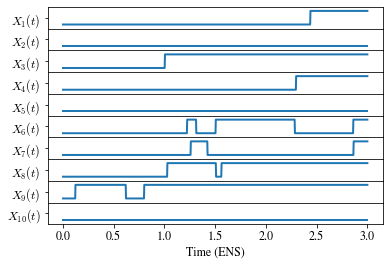

In [322]:
init_geno = np.eye(K)[np.zeros(L).astype(np.int)] # Initial genotype
g_t = evolve_genotype(init_geno)
g_t = np.array([np.where(g_t[i])[1] for i in range(len(g_t))])
plot_genotype(g_t)

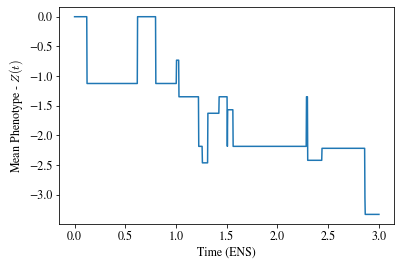

In [323]:
plot_phenotype(g_t, beta)

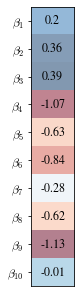

In [261]:
plt.figure(figsize=(1, 4))
plt.imshow(beta[:, 1:], cmap='RdBu', alpha=0.5, aspect='auto')
plt.xticks([])
plt.yticks(np.arange(L), ['$\\beta_{%d}$' % (i + 1) for i in range(L)])
for j in range(len(beta)):
    text = plt.text(0, j, np.round(beta[j, 1], 2),
                   ha="center", va="center", color="black")
plt.tight_layout(pad=0.2)
plt.savefig("./appendix_vis/fig1_b.svg")

# Moments of Mean Phenotype

In [376]:
n_replicates=100

#init_geno = np.eye(K)[np.random.choice(2, size=L, p=[0.9, 0.1]).astype(np.int)] # Initial genotype
init_geno = np.eye(K)[np.array([1, 1, 1, 0, 0, 0, 0, 0, 0, 0])]

res = []

for _ in  range(n_replicates):
    gt = evolve_genotype(init_geno)
    res.append(np.array([np.where(gt[i])[1] for i in range(len(gt))]))


<Figure size 432x288 with 0 Axes>

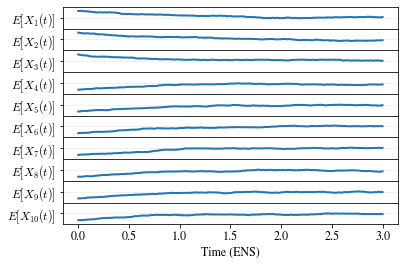

In [390]:
expected_genotype = np.zeros_like(res[0])
for i in range(n_replicates):
    expected_genotype += res[i]
    
plot_genotype(expected_genotype / n_replicates, fig_file="./appendix_vis/fig3a.svg", expectation=True)

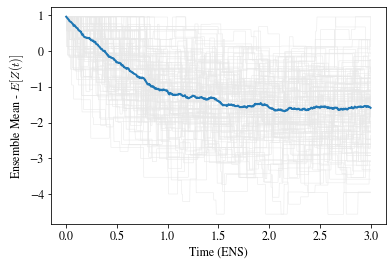

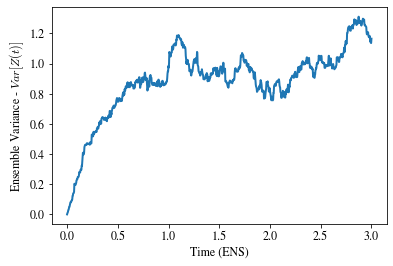

In [389]:
plot_ensemble_moments(res, beta, mean_fig_file="./appendix_vis/fig3b.svg", var_fig_file="./appendix_vis/fig3c.svg")

In [2]:
from Bio import AlignIO, Phylo
import pandas as pd
import numpy as np
from gp_models.gp_models import GaussianProcessModel, NeutralModel, OU, BM
%load_ext autoreload
%autoreload 2

In [19]:
erv_data = pd.read_csv("ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/segment_7916_8695/traits.csv", index_col=0).T
erv_tree = Phylo.read("ancient_erv_analysis/metadata/segment_trees/paml_inferred/segment_7916_8695.nwk", "newick")

nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.37, 'Zeq': 0.36, 'sigma_eq': 0.000288})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.79868019120283,
 'DOF': 2,
 'AIC': -259.59736038240567,
 'AIC.c': -259.27303605808135,
 'BIC': -256.2196014741778,
 'Parameters': {'Z0': 0.45064921905129823,
  'Zeq': 0.36,
  'Psi': 0.001466726654975338,
  'sigma_eq': 0.000288,
  'u': 1.37}}

In [36]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.00031})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 133.3038790819269,
 'DOF': 2,
 'AIC': -262.6077581638538,
 'AIC.c': -262.2834338395295,
 'BIC': -259.22999925562596,
 'Parameters': {'Z0': 0.4286605308041588,
  'Zeq': 0.44,
  'Psi': 0.0013519381029283538,
  'sigma_eq': 0.00031,
  'u': 1.34}}

In [37]:
nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34})
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.25707429348367,
 'DOF': 4,
 'AIC': -260.51414858696734,
 'AIC.c': -259.37129144411017,
 'BIC': -253.7586307705116,
 'Parameters': {'Z0': 0.4297984876708193,
  'Zeq': 0.4359537231454264,
  'Psi': 9.99999997437784e-13,
  'sigma_eq': 0.0025563088548873187,
  'u': 1.34}}

In [38]:
nm = NeutralModel(erv_data['gc_content'], erv_tree)
nm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 134.90977876586916,
 'DOF': 5,
 'AIC': -259.8195575317383,
 'AIC.c': -258.0548516493854,
 'BIC': -251.37516026116865,
 'Parameters': {'Z0': 0.4298567820580272,
  'Zeq': 0.4341898649481175,
  'Psi': 9.999999960041972e-13,
  'sigma_eq': 0.0012508851221227223,
  'u': 2.0}}

In [41]:
ou = OU(erv_data['gc_content'], erv_tree)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7563195304113,
 'DOF': 4,
 'AIC': -271.5126390608226,
 'AIC.c': -270.36978191796544,
 'BIC': -264.7571212443669,
 'Parameters': {'Z0': 0.4294136384780781,
  'Zeq': 0.4320629759227744,
  'sigma': 0.003293928936528404,
  'alpha': 18.468859845082363}}

In [44]:
ou = OU(erv_data['gc_content'], erv_tree, equilibrium_z0=True)
ou.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 139.7548962775069,
 'DOF': 3,
 'AIC': -273.5097925550138,
 'AIC.c': -272.8431258883471,
 'BIC': -268.443154192672,
 'Parameters': {'Zeq': 0.43201396720676144,
  'sigma': 0.003283819918767566,
  'alpha': 18.382295122779674}}

In [43]:
bm = BM(erv_data['gc_content'], erv_tree)
bm.fit()

{'Optimization': {'Success': True,
  'Message': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'},
 'Loglikelihood': 131.68912822706005,
 'DOF': 2,
 'AIC': -259.3782564541201,
 'AIC.c': -259.0539321297958,
 'BIC': -256.00049754589224,
 'Parameters': {'Z0': 0.43090571681745277, 'sigma': 0.0015004967278711004}}

In [169]:
import sys
sys.path.insert(0, "ancient_erv_analysis")
from compute_q_traits import calculate_gc_content

def plot_nll(segment):

    erv_data = pd.read_csv(f"ancient_erv_analysis/data/3_q_traits/2_simulated_sequences/{segment}/traits.csv", index_col=0).T
    erv_tree = Phylo.read(f"ancient_erv_analysis/metadata/segment_trees/paml_inferred/{segment}.nwk", "newick")
    
    with open(f"ancient_erv_analysis/data/2_simulated_sequences/{segment}/alignment.root", "r") as algn_f:
        root_seq = str(algn_f.read()).strip()
        
    true_z0 = calculate_gc_content(root_seq)
    
    nm = NeutralModel(erv_data['gc_content'], erv_tree, fixed_params={'u': 1.34, 'Zeq': 0.44, 'sigma_eq': 0.2464/len(root_seq)})
    nm.fit()

    z0 = np.linspace(0., 1., 100)
    L = 800

    psi = (1./L)*(0.44 + z0 -2.*z0*0.44)

    nll = []

    for i in range(100):
        nm.z0 = z0[i]
        nm.psi = psi[i]
        nll.append(nm.nll())

    plt.plot(z0, nll)
    plt.axvline(true_z0, c='red', ls='--', label='True Z0')
    plt.xlabel("Z0")
    plt.ylabel("NLL")
    plt.title(f"GC Content - {segment}")
    plt.legend()
    plt.show()

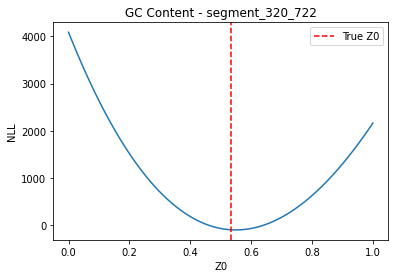

In [171]:
plot_nll('segment_320_722')

In [35]:
res_python = pd.read_csv("gp_models/model_fit_results/true_seq_paml_inf_tree.csv", index_col=0)
res_python = res_python.loc[res_python['Model'].isin(['BM', 'OU (Z0=Zeq)', 'NeutralModel (fixed u=1.34)', 'NeutralModel (Z0=Zeq, fixed u=1.34)']), 
                            ['Trait', 'Sequence', 'Model', 'Log-likelihood', 'Corrected AIC', 'Z0']]

res_python['Trait'] = res_python['Trait'].replace({'gc_content': 'GC Content', 'A_percent':'Percent of A', 
                       'longest_ORF': 'Longest ORF', 'longest_ORF_alan': 'Longest ORF (Alan)'})
res_python['Model'] = res_python['Model'].replace({'OU (Z0=Zeq)': 'OU'})
res_python.columns = ['trait', 'segment', 'Model', 'loglik', 'aicc', 'z0']

res_python=pd.DataFrame(res_python.pivot(index=['trait','segment'], columns='Model', values=['loglik', 'aicc', 'z0']).to_records())
res_python.columns=['trait', 'segment', 'BM_loglik', 'NM2_loglik', 'NM4_loglik', 'OU_loglik', 'BM_aicc', 'NM2_aicc', 'NM4_aicc', 'OU_aicc', 'BM_z0', 'NM2_z0', 'NM4_z0', 'OU_z0']
res_python = res_python.sort_values(['segment', 'trait'])
res_python

trait                      segment   BM_loglik  NM2_loglik  \
0           GC Content          segment_10270_10563  102.526381  102.546539   
15         Longest ORF          segment_10270_10563   91.772071   90.211125   
30  Longest ORF (Alan)          segment_10270_10563 -145.995579 -145.104347   
45        Percent of A          segment_10270_10563  122.492783  122.478368   
1           GC Content  segment_10270_10563_141_191  104.988280  105.182692   
16         Longest ORF  segment_10270_10563_141_191  174.524271  175.949227   
31  Longest ORF (Alan)  segment_10270_10563_141_191  -87.825329  -86.607440   
46        Percent of A  segment_10270_10563_141_191  117.792979  117.790723   
2           GC Content          segment_11196_11705  124.994966  123.898287   
17         Longest ORF          segment_11196_11705  105.736666  103.260167   
32  Longest ORF (Alan)          segment_11196_11705 -160.747078 -158.879621   
47        Percent of A          segment_11196_11705  138.907894  138.425993   
3           GC Content  segment_11196_11705_116_166  157.038807  154.772486   
18         Longest ORF  segment_11196_11705_116_166  274.932377  272.828616   
33  Longest ORF (Alan)  segment_11196_11705_116_166  -48.646111  -47.704475   
48        Percent of A  segment_11196_11705_116_166  154.455259  154.266875   
4           GC Content  segment_11196_11705_224_274  123.397206  121.446663   
19         Longest ORF  segment_11196_11705_224_274  165.586716  166.228285   
34  Longest ORF (Alan)  segment_11196_11705_224_274  -65.930859  -65.025377   
49        Percent of A  segment_11196_11705_224_274  137.636415  136.804871   
5           GC Content          segment_11935_12275  114.530678  114.311889   
20         Longest ORF          segment_11935_12275   70.072312   71.389468   
35  Longest ORF (Alan)          segment_11935_12275 -127.262459 -126.547533   
50        Percent of A          segment_11935_12275  138.689271  138.692220   
6           GC Content  segment_11935_12275_204_254  121.824111  121.115171   
21         Longest ORF  segment_11935_12275_204_254  206.445647  204.542514   
36  Longest ORF (Alan)  segment_11935_12275_204_254  -38.376128  -39.441372   
51        Percent of A  segment_11935_12275_204_254  131.152321  131.536602   
7           GC Content              segment_320_722  113.193080  110.043793   
22         Longest ORF              segment_320_722   75.863115   76.934593   
37  Longest ORF (Alan)              segment_320_722 -154.107997 -153.217986   
52        Percent of A              segment_320_722  133.295253  131.746607   
8           GC Content            segment_7916_8695  124.062479  123.639247   
23         Longest ORF            segment_7916_8695   78.193423   80.567762   
38  Longest ORF (Alan)            segment_7916_8695 -167.632930 -166.060194   
53        Percent of A            segment_7916_8695  136.797941  136.814659   
9           GC Content    segment_7916_8695_389_439  112.682714  112.572463   
24         Longest ORF    segment_7916_8695_389_439  247.598207  246.879573   
39  Longest ORF (Alan)    segment_7916_8695_389_439  -52.312526  -53.235183   
54        Percent of A    segment_7916_8695_389_439  126.722818  126.072175   
10          GC Content    segment_7916_8695_466_516   74.373926   76.237898   
25         Longest ORF    segment_7916_8695_466_516   86.322531   88.139988   
40  Longest ORF (Alan)    segment_7916_8695_466_516  -57.468475  -56.924174   
55        Percent of A    segment_7916_8695_466_516   45.693701   47.688631   
11          GC Content    segment_7916_8695_585_635   88.387802   89.961994   
26         Longest ORF    segment_7916_8695_585_635   96.617543   98.354497   
41  Longest ORF (Alan)    segment_7916_8695_585_635  -48.818874  -47.779110   
56        Percent of A    segment_7916_8695_585_635  103.138051  104.595871   
12          GC Content    segment_7916_8695_647_697  137.640803  135.912641   
27         Longest ORF    segment_7916_8695_647_697  144.260817  14

In [36]:
res_geiger = pd.read_csv("ancient_erv_analysis/geiger_inference/Real Sequences.csv", index_col=0)
res_geiger = res_geiger[['trait', 'segment', 'BM_loglik', 'OU_loglik', 'BM_aicc', 'OU_aicc', 'BM_z0', 'OU_z0']]
res_geiger = res_geiger.sort_values(['segment', 'trait'])
res_geiger

trait                      segment   BM_loglik   OU_loglik  \
1           GC Content          segment_10270_10563  102.526381  102.589162   
2          Longest ORF          segment_10270_10563   91.772071   91.789053   
4   Longest ORF (Alan)          segment_10270_10563 -145.995579 -143.260235   
3         Percent of A          segment_10270_10563  122.492783  122.520407   
5           GC Content  segment_10270_10563_141_191  104.988280  105.206425   
6          Longest ORF  segment_10270_10563_141_191  174.524271  180.856318   
8   Longest ORF (Alan)  segment_10270_10563_141_191  -87.825329  -85.813626   
7         Percent of A  segment_10270_10563_141_191  117.792979  117.806504   
9           GC Content          segment_11196_11705  124.994966  125.003728   
10         Longest ORF          segment_11196_11705  105.736666  105.737573   
12  Longest ORF (Alan)          segment_11196_11705 -160.742614 -150.500365   
11        Percent of A          segment_11196_11705  138.907894  138.998727   
13          GC Content  segment_11196_11705_116_166  157.038807  157.040068   
14         Longest ORF  segment_11196_11705_116_166  274.932378  274.933240   
16  Longest ORF (Alan)  segment_11196_11705_116_166  -48.646005  -46.047079   
15        Percent of A  segment_11196_11705_116_166  154.455259  154.494435   
17          GC Content  segment_11196_11705_224_274  123.397206  123.397292   
18         Longest ORF  segment_11196_11705_224_274  165.586716  167.005332   
20  Longest ORF (Alan)  segment_11196_11705_224_274  -65.930773  -62.807924   
19        Percent of A  segment_11196_11705_224_274  137.636415  137.639879   
21          GC Content          segment_11935_12275  114.530678  114.601431   
22         Longest ORF          segment_11935_12275   70.072312   75.070163   
24  Longest ORF (Alan)          segment_11935_12275 -127.261740 -126.141286   
23        Percent of A          segment_11935_12275  138.689271  138.734150   
25          GC Content  segment_11935_12275_204_254  121.824111  121.824779   
26         Longest ORF  segment_11935_12275_204_254  206.445647  206.445824   
28  Longest ORF (Alan)  segment_11935_12275_204_254  -38.376037  -38.372525   
27        Percent of A  segment_11935_12275_204_254  131.152321  131.566040   
29          GC Content              segment_320_722  113.193080  113.194668   
30         Longest ORF              segment_320_722   75.863115   78.606460   
32  Longest ORF (Alan)              segment_320_722 -154.107988 -152.759762   
31        Percent of A              segment_320_722  133.295253  133.345578   
33          GC Content            segment_7916_8695  124.062479  124.083317   
34         Longest ORF            segment_7916_8695   78.193423   97.851175   
36  Longest ORF (Alan)            segment_7916_8695 -167.632921 -160.144132   
35        Percent of A            segment_7916_8695  136.797941  136.854430   
37          GC Content    segment_7916_8695_389_439  112.682714  112.687824   
38         Longest ORF    segment_7916_8695_389_439  247.598207  247.629744   
40  Longest ORF (Alan)    segment_7916_8695_389_439  -52.312525  -52.254061   
39        Percent of A    segment_7916_8695_389_439  126.722818  126.746186   
41          GC Content    segment_7916_8695_466_516   74.373926   99.901653   
42         Longest ORF    segment_7916_8695_466_516   86.322531  104.658482   
44  Longest ORF (Alan)    segment_7916_8695_466_516  -57.468407  -56.090119   
43        Percent of A    segment_7916_8695_466_516   45.693701  108.684227   
45          GC Content    segment_7916_8695_585_635   88.387802  111.463634   
46         Longest ORF    segment_7916_8695_585_635   96.617543  201.540027   
48  Longest ORF (Alan)    segment_7916_8695_585_635  -48.818874  -44.667184   
47        Percent of A    segment_7916_8695_585_635  103.138051  118.319542   
49          GC Content    segment_7916_8695_647_697  137.640803  137.641969   
50         Longest ORF    segment_7916_8695_647_697  144.260817  14

In [53]:
m_res = pd.merge(res_geiger, res_python, on=['trait', 'segment'], suffixes=('_geiger', '_python'))
comp_res = m_res[['trait', 'segment'] + sorted(m_res.columns[2:])] 
comp_res.to_csv("comparison_table.csv", index=False)
comp_res

trait                      segment  BM_aicc_geiger  \
0           GC Content          segment_10270_10563     -200.709905   
1          Longest ORF          segment_10270_10563     -179.201285   
2   Longest ORF (Alan)          segment_10270_10563      296.334014   
3         Percent of A          segment_10270_10563     -240.642708   
4           GC Content  segment_10270_10563_141_191     -205.633703   
5          Longest ORF  segment_10270_10563_141_191     -344.705685   
6   Longest ORF (Alan)  segment_10270_10563_141_191      179.993514   
7         Percent of A  segment_10270_10563_141_191     -231.243100   
8           GC Content          segment_11196_11705     -245.656599   
9          Longest ORF          segment_11196_11705     -207.140000   
10  Longest ORF (Alan)          segment_11196_11705      325.818560   
11        Percent of A          segment_11196_11705     -273.482455   
12          GC Content  segment_11196_11705_116_166     -309.744281   
13         Longest ORF  segment_11196_11705_116_166     -545.531423   
14  Longest ORF (Alan)  segment_11196_11705_116_166      101.625344   
15        Percent of A  segment_11196_11705_116_166     -304.577186   
16          GC Content  segment_11196_11705_224_274     -242.461079   
17         Longest ORF  segment_11196_11705_224_274     -326.840098   
18  Longest ORF (Alan)  segment_11196_11705_224_274      136.194878   
19        Percent of A  segment_11196_11705_224_274     -270.939496   
20          GC Content          segment_11935_12275     -224.708414   
21         Longest ORF          segment_11935_12275     -135.791682   
22  Longest ORF (Alan)          segment_11935_12275      258.876421   
23        Percent of A          segment_11935_12275     -273.025602   
24          GC Content  segment_11935_12275_204_254     -239.295281   
25         Longest ORF  segment_11935_12275_204_254     -408.538353   
26  Longest ORF (Alan)  segment_11935_12275_204_254       81.105015   
27        Percent of A  segment_11935_12275_204_254     -257.951700   
28          GC Content              segment_320_722     -222.043303   
29         Longest ORF              segment_320_722     -147.383372   
30  Longest ORF (Alan)              segment_320_722      312.558834   
31        Percent of A              segment_320_722     -262.247648   
32          GC Content            segment_7916_8695     -243.800634   
33         Longest ORF            segment_7916_8695     -152.062523   
34  Longest ORF (Alan)            segment_7916_8695      339.590166   
35        Percent of A            segment_7916_8695     -269.271558   
36          GC Content    segment_7916_8695_389_439     -221.041104   
37         Longest ORF    segment_7916_8695_389_439     -490.872091   
38  Longest ORF (Alan)    segment_7916_8695_389_439      108.949374   
39        Percent of A    segment_7916_8695_389_439     -249.121311   
40          GC Content    segment_7916_8695_466_516     -144.423528   
41         Longest ORF    segment_7916_8695_466_516     -168.320738   
42  Longest ORF (Alan)    segment_7916_8695_466_516      119.261138   
43        Percent of A    segment_7916_8695_466_516      -87.063077   
44          GC Content    segment_7916_8695_585_635     -172.451280   
45         Longest ORF    segment_7916_8695_585_635     -188.910761   
46  Longest ORF (Alan)    segment_7916_8695_585_635      101.962073   
47        Percent of A    segment_7916_8695_585_635     -201.951778   
48          GC Content    segment_7916_8695_647_697     -270.957281   
49         Longest ORF    segment_7916_8695_647_697     -284.197310   
50  Longest ORF (Alan)    segment_7916_8695_647_697      112.282599   
51        Percent of A    segment_7916_8695_647_697     -302.697293   
52          GC Content            segment_8305_8605     -251.995072   
53         Longest ORF            segment_8305_8605     -175.438970   
54  Longest ORF (Alan)            segment_8305_8605      311.085778   
55        Percent of A            segment

# Plotting results

In [333]:
df = pd.read_csv("gp_models/model_fit_results/simulated_seq_paml_inf_tree.csv", index_col=0)
df = df.loc[df['Trait'] != 'longest_ORF_alan']
df['True Zeq'] = df['Trait'].map({'gc_content': .44, 'A_percent': .28})
df['Absolute Relative Error (Zeq)'] = np.abs((df['Zeq'] - df['True Zeq']) / df['True Zeq'])
df['Absolute Relative Error'] = np.abs((df['Z0'] - df['True Z0']) / df['True Z0'])
df['Relative Error']= (df['Z0'] - df['True Z0']) / df['True Z0']
df

Trait           Sequence  ... Absolute Relative Error  Relative Error
0    gc_content  segment_8938_9248  ...                0.005616        0.005616
1    gc_content  segment_8938_9248  ...                0.050191       -0.050191
2    gc_content  segment_8938_9248  ...                0.016583        0.016583
3    gc_content  segment_8938_9248  ...                0.015814        0.015814
4    gc_content  segment_8938_9248  ...                1.349022       -1.349022
..          ...                ...  ...                     ...             ...
134   A_percent  segment_7916_8695  ...                0.021073       -0.021073
135   A_percent  segment_7916_8695  ...                0.013867       -0.013867
136   A_percent  segment_7916_8695  ...                0.009846       -0.009846
137   A_percent  segment_7916_8695  ...                0.009846       -0.009846
138   A_percent  segment_7916_8695  ...                0.009847       -0.009847

[114 rows x 14 columns]

In [332]:
df['Trait'].map({'gc_content': .44, 'A_percent': .28})

0      0.44
1      0.44
2      0.44
3      0.44
4      0.44
       ... 
134    0.28
135    0.28
136    0.28
137    0.28
138    0.28
Name: Trait, Length: 114, dtype: float64

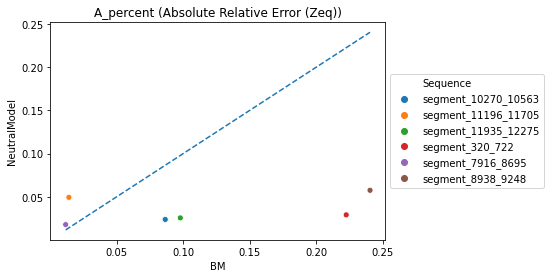

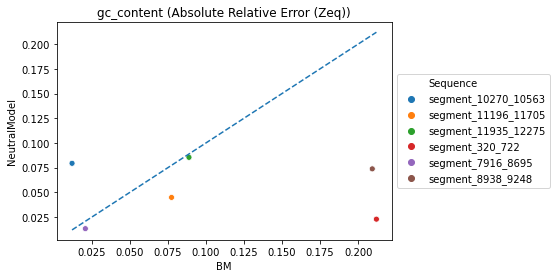

No handles with labels found to put in legend.


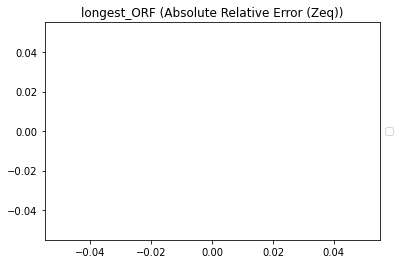

In [335]:
metric = 'Absolute Relative Error (Zeq)'

mdf = df.pivot(index=['Trait', 'Sequence'], columns='Model', values=metric).reset_index()

x_model = 'BM' #'OU (Z0=Zeq)'
y_model = 'NeutralModel'

for t in mdf['Trait'].unique():
    t_mdf = mdf.loc[mdf['Trait'] == t]
    ax = sns.scatterplot(data=t_mdf, x=x_model, y=y_model, hue="Sequence")
    x = np.linspace(t_mdf[[x_model, y_model]].min().min(), t_mdf[[x_model, y_model]].max().max(), 1000)
    plt.plot(x, x, ls='--')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(t + f' ({metric})')
    plt.show()

In [127]:
mdf['Trait'].unique()

array(['gc_content', 'longest_ORF', 'A_percent', 'longest_ORF_alan'],
      dtype=object)

Text(0.5, 1.0, 'Corrected AIC Difference with respect to OU')

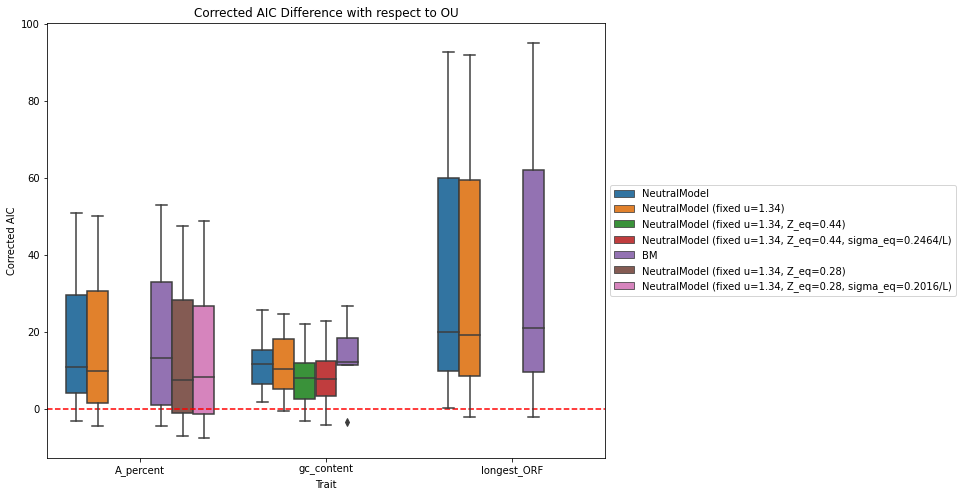

In [318]:
metric = 'Corrected AIC'
ref = 'OU'
exclude_models = ['OU (Z0=Zeq)']

mdf = df.pivot(index=['Trait', 'Sequence'], columns='Model', values=metric).reset_index()

for m in df['Model'].unique():
    if m != ref:
        mdf[m] -= mdf[ref]
        
melt_df = pd.melt(mdf, id_vars=('Trait', 'Sequence'),
                  value_vars=[m for m in df['Model'].unique() if m != ref and m not in exclude_models],
                  value_name=metric)

plt.figure(figsize=(10, 8))
ax = sns.boxplot(x="Trait", y=metric, hue="Model", data=melt_df)
plt.axhline(y=0., ls='--', c='r', zorder=1)
#plt.ylim([-.1, .1])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(f'{metric} Difference with respect to {ref}')

In [651]:
res_df = pd.read_csv("simulation_analysis/data/inference_results_20.csv")
res_df

Trait  Simulation             BaseFreq  ...  Inferred Z0  True Zeq  Inferred Zeq
0       gc_content          97  0.28_0.22_0.22_0.28  ...     3.808695      0.44      0.352219
1       gc_content          97  0.28_0.22_0.22_0.28  ...     2.346248      0.44      0.309448
2       gc_content          97  0.28_0.22_0.22_0.28  ...     0.368633      0.44      0.440000
3       gc_content          97  0.28_0.22_0.22_0.28  ...     6.000920      0.44      0.350835
4       gc_content          97  0.28_0.22_0.22_0.28  ...     0.432878      0.44      0.432878
...            ...         ...                  ...  ...          ...       ...           ...
215995   A_percent          71  0.25_0.25_0.25_0.25  ...     0.348324      0.25     -0.097901
215996   A_percent          71  0.25_0.25_0.25_0.25  ...    -0.004340      0.25      0.250000
215997   A_percent          71  0.25_0.25_0.25_0.25  ...     0.902176      0.25      0.061969
215998   A_percent          71  0.25_0.25_0.25_0.25  ...     0.123119      0.25      0.123119
215999   A_percent          71  0.25_0.25_0.25_0.25  ...     0.123119      0.25      0.123119

[216000 rows x 12 columns]

/Users/szabad/opt/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'Bias ($\\hat{Z_0} - Z_0$)')

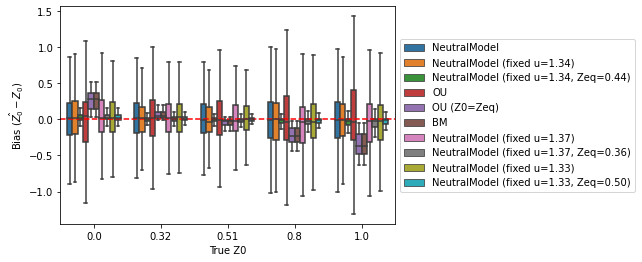

In [669]:
m_res_df = res_df.loc[res_df['Trait'].isin(['gc_content'])]
m_res_df['Bias'] = m_res_df['Inferred Z0'] - m_res_df['True Z0']
ax = sns.boxplot(y='Bias', x='True Z0', hue='Model', data=m_res_df, showfliers = False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.axhline(y=0., ls='--', c='r', zorder=1)
plt.ylabel("Bias ($\hat{Z_0} - Z_0$)")

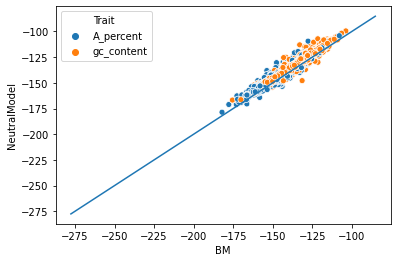

In [637]:
mdf = res_df.pivot(index=['BaseFreq','TVRatio','ScaleFactor','InitialSequence', 'Trait', 'Simulation'],
                   columns='Model', values='AICc').reset_index()

mdf = mdf.loc[mdf['Trait'] != 'gaussian_es_trait']

x = 'BM'
y = 'NeutralModel'

sns.scatterplot(data=mdf.loc[mdf['ScaleFactor'] == 20], x=x, y=y, hue='Trait')
lins = np.linspace(mdf[[x, y]].min().min(), mdf[[x, y]].max().max(), 1000)
plt.plot(lins, lins)

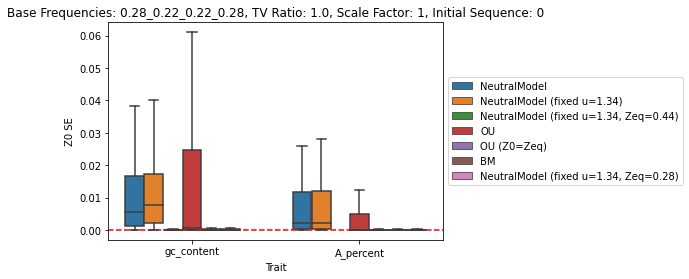

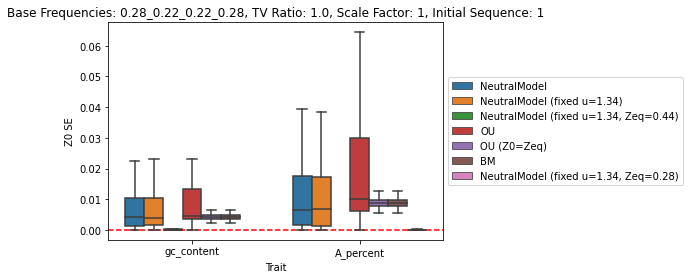

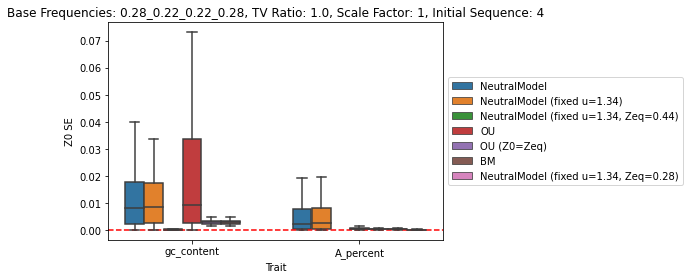

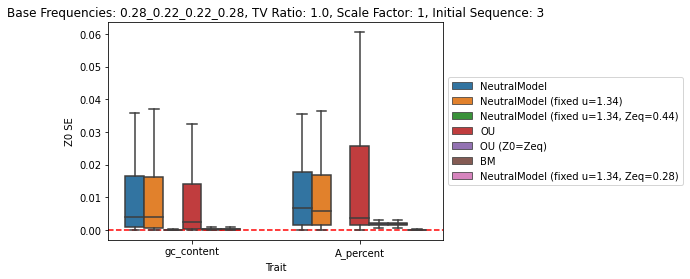

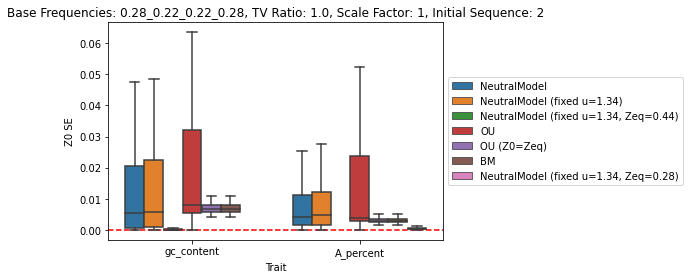

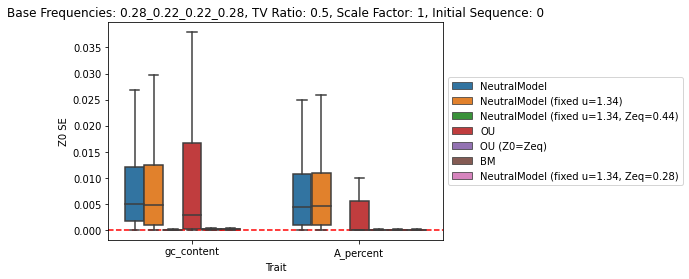

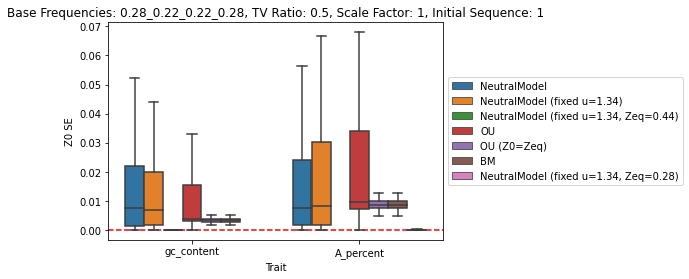

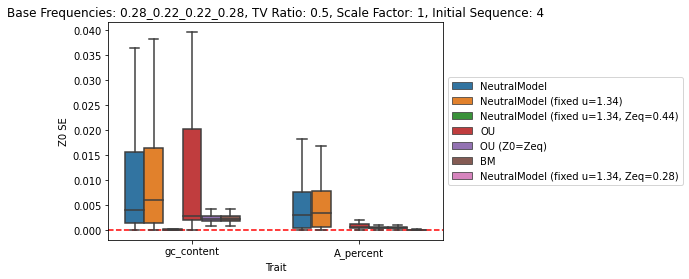

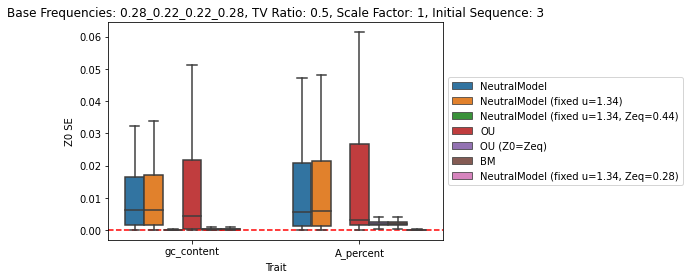

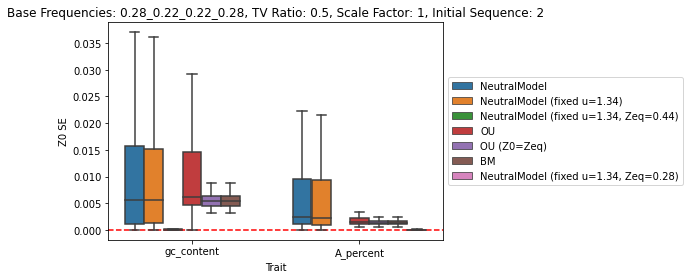

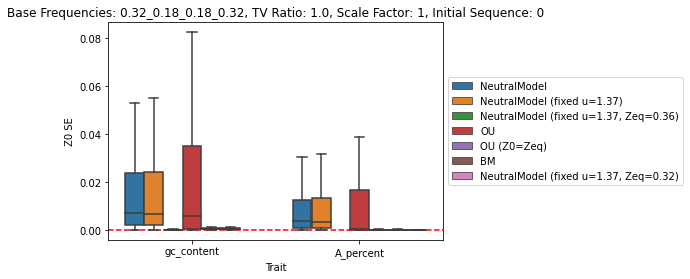

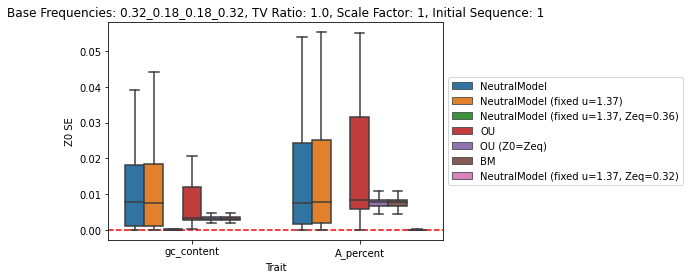

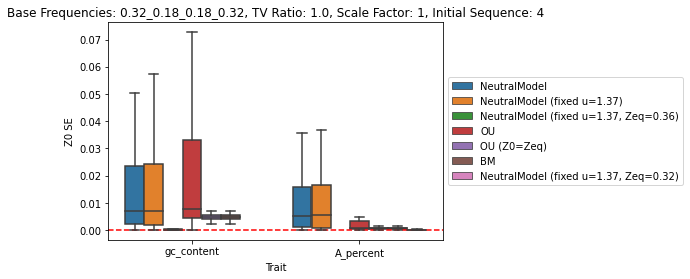

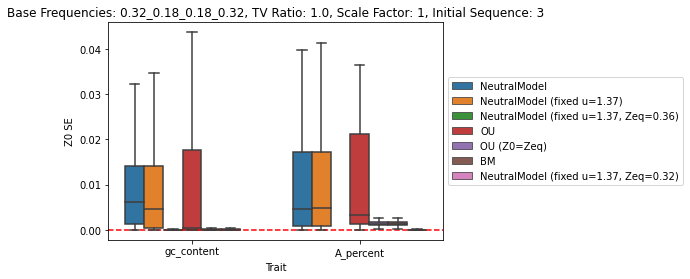

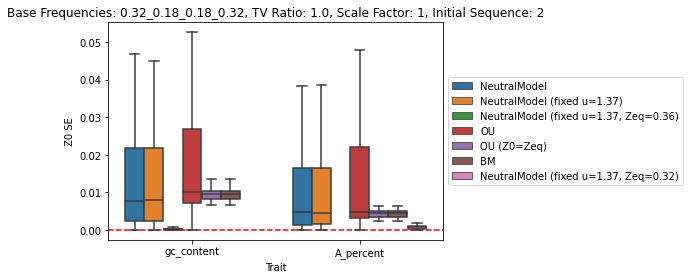

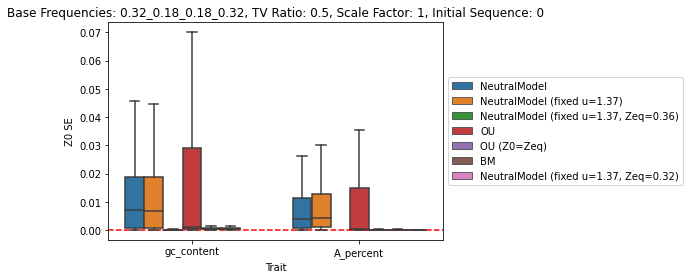

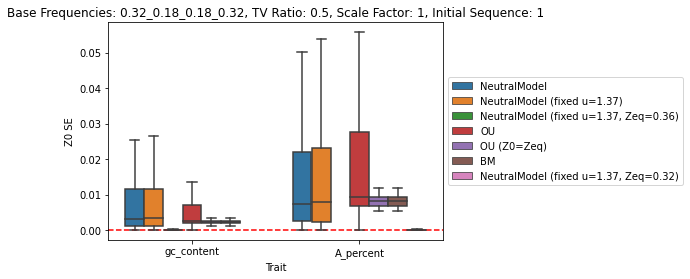

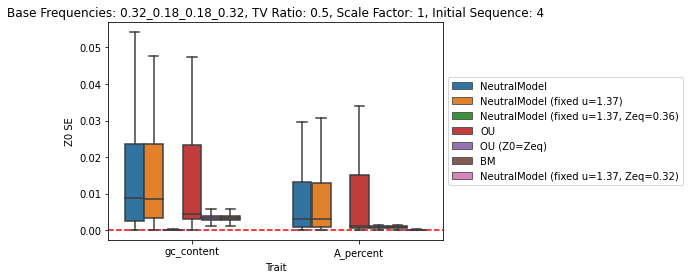

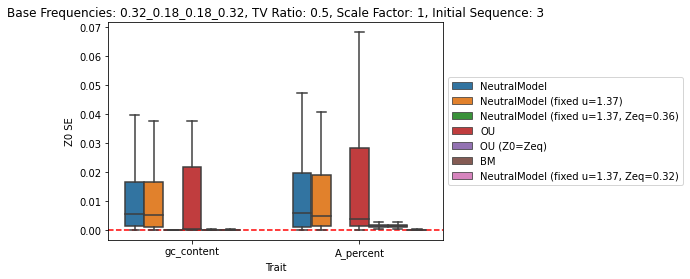

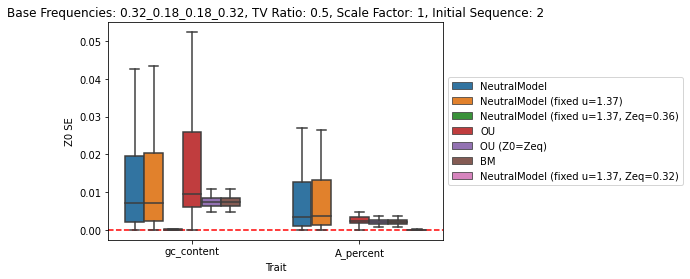

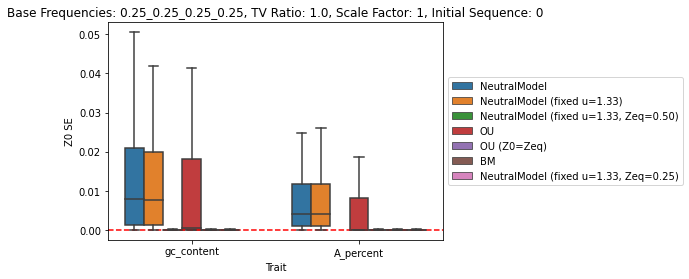

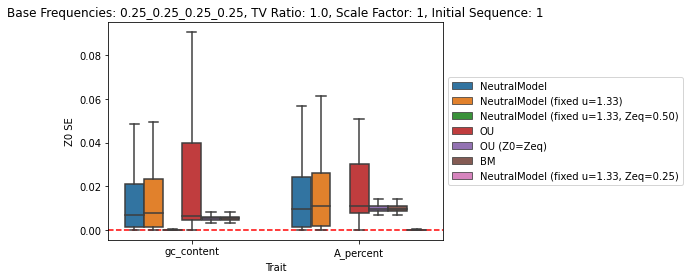

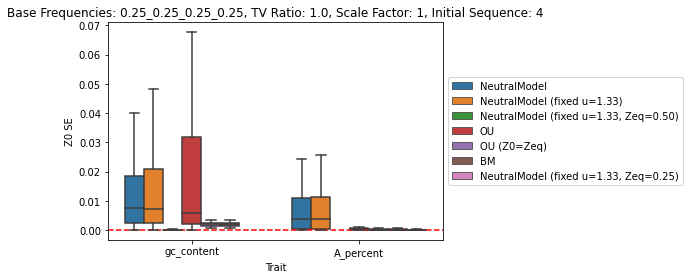

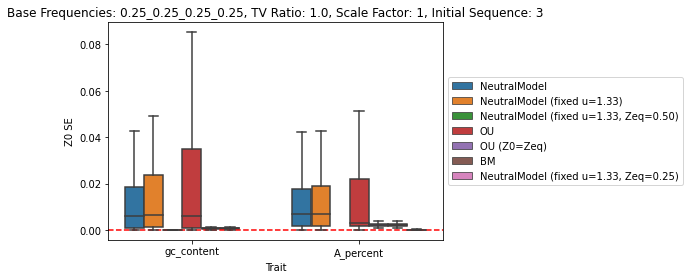

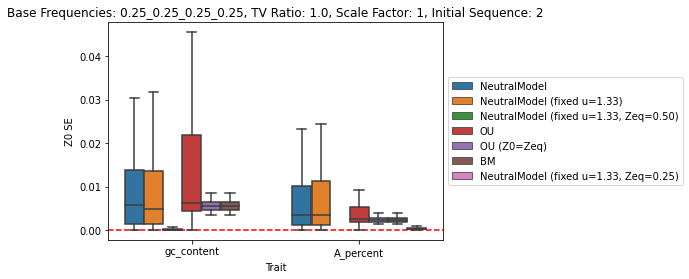

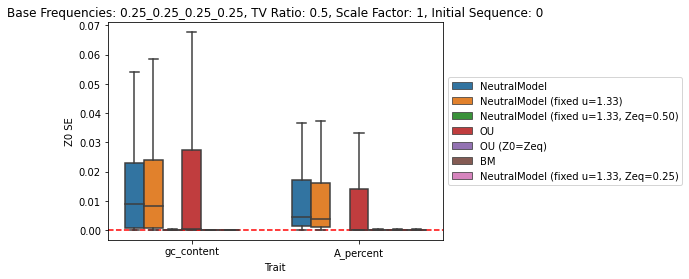

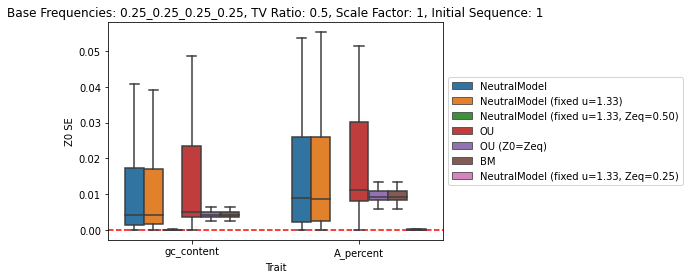

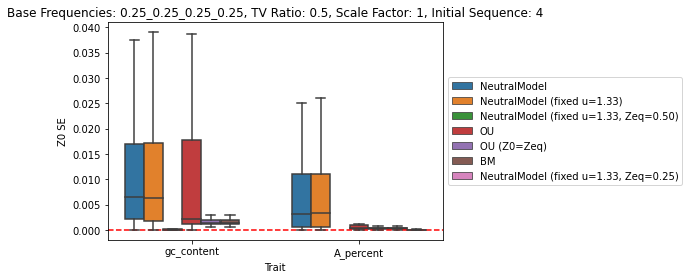

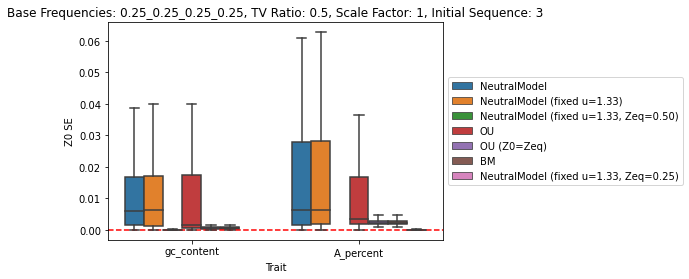

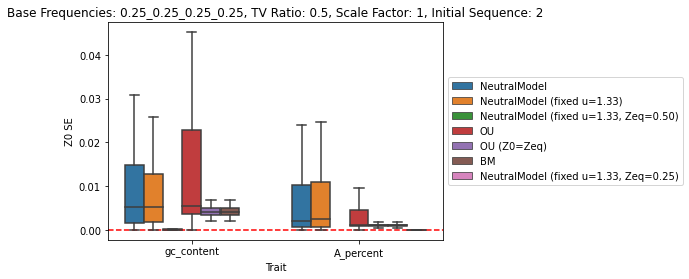

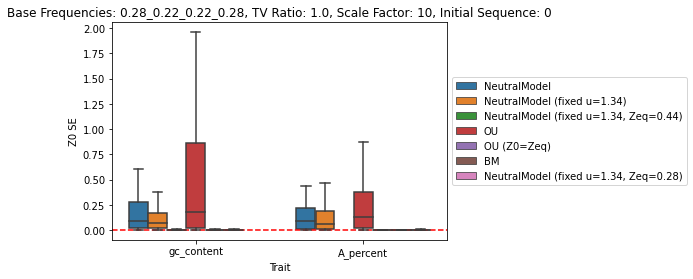

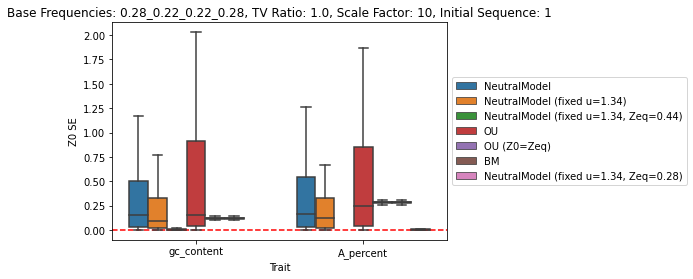

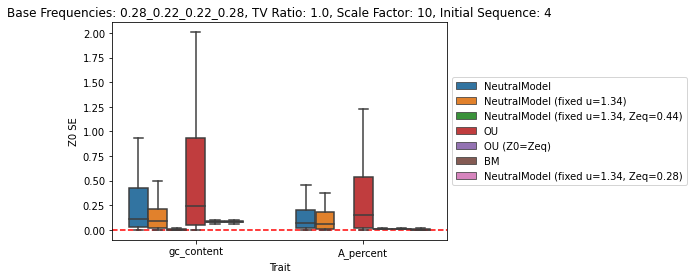

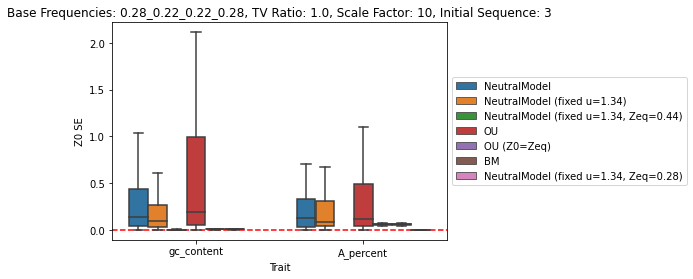

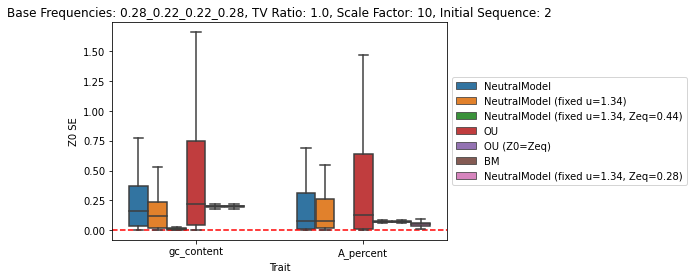

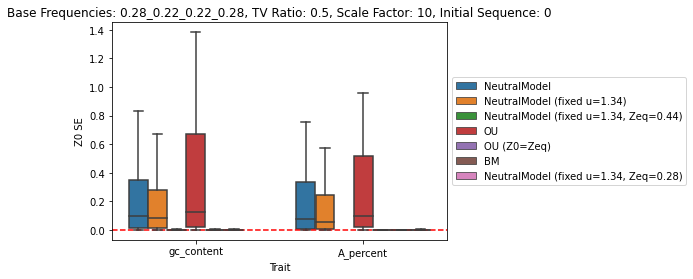

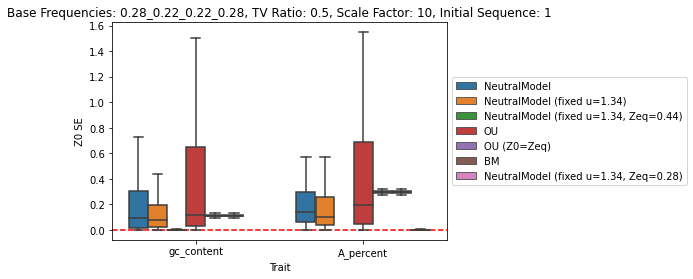

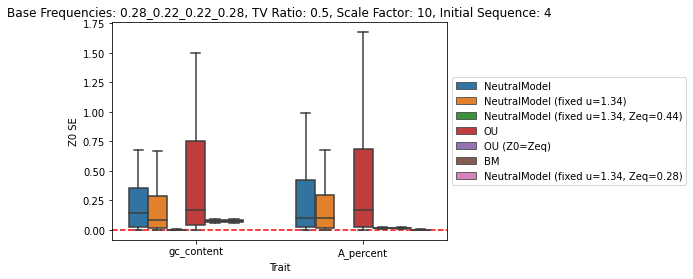

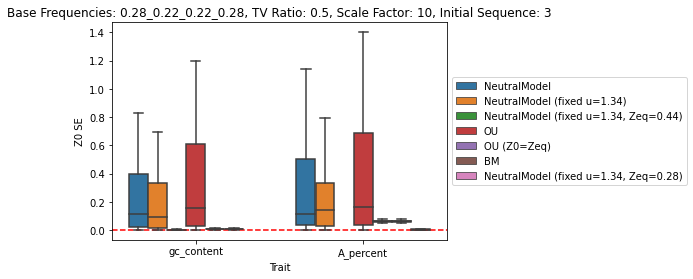

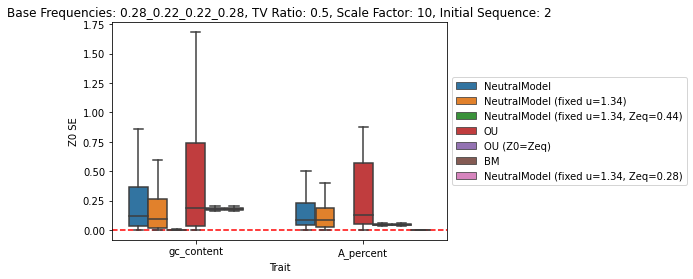

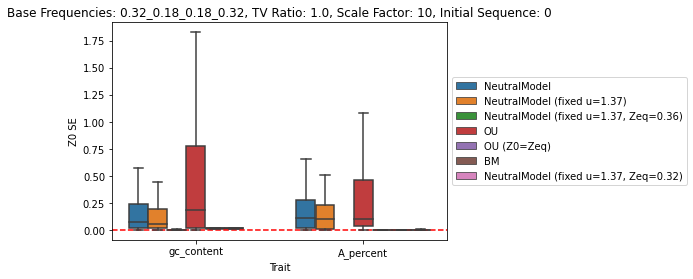

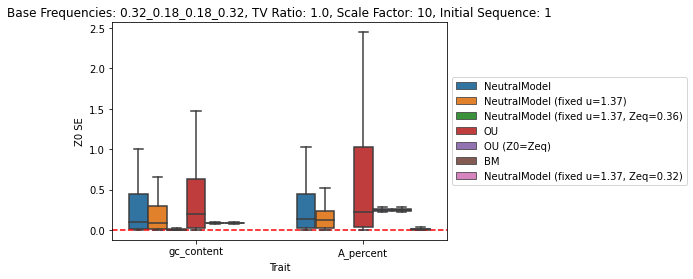

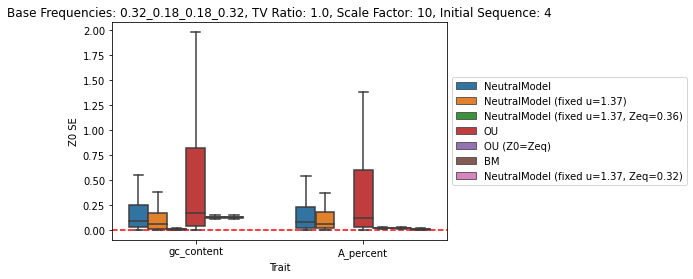

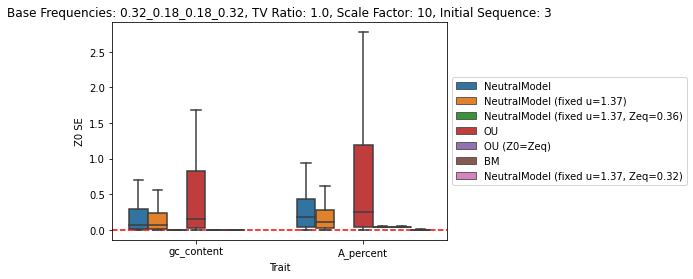

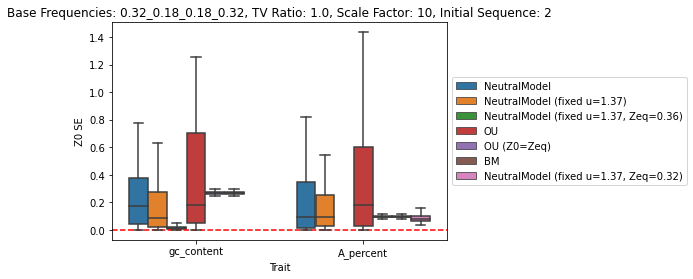

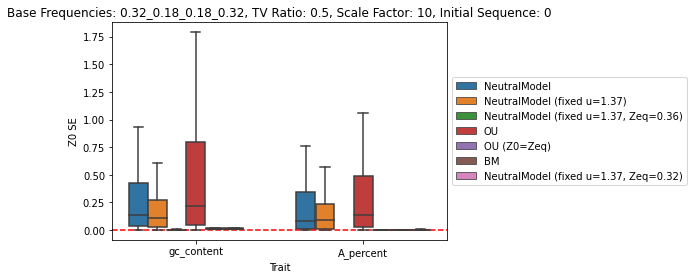

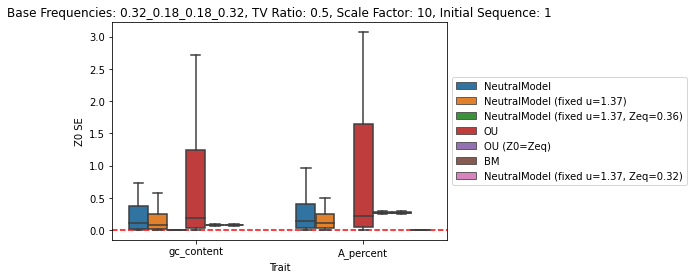

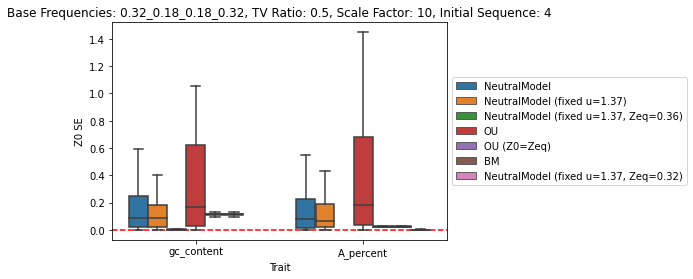

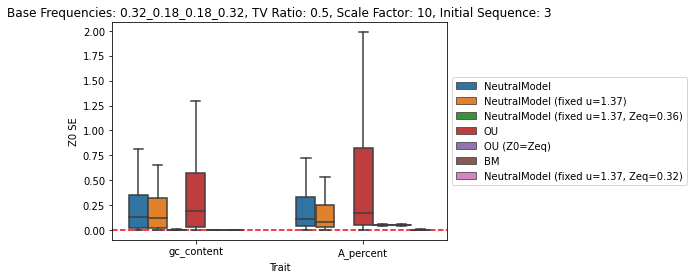

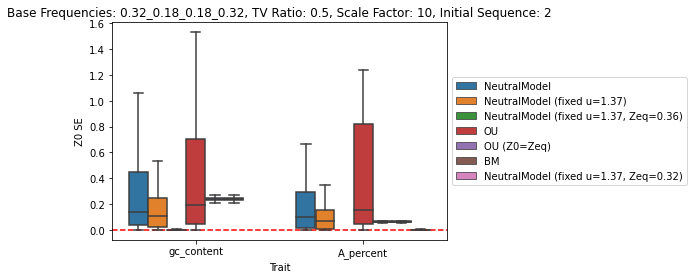

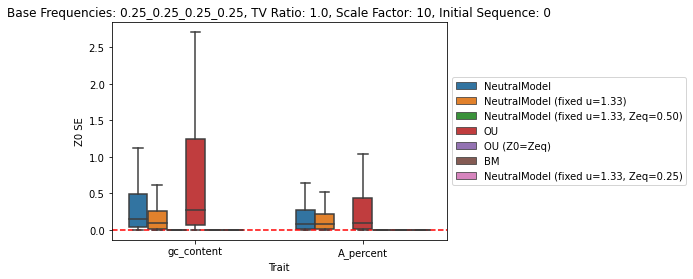

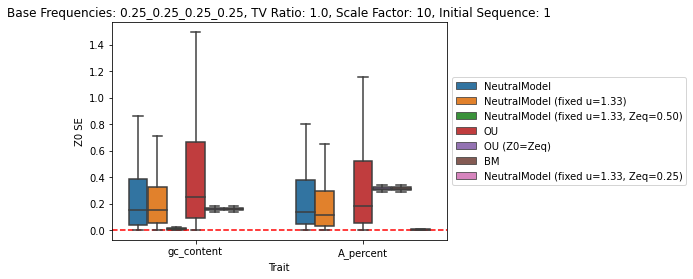

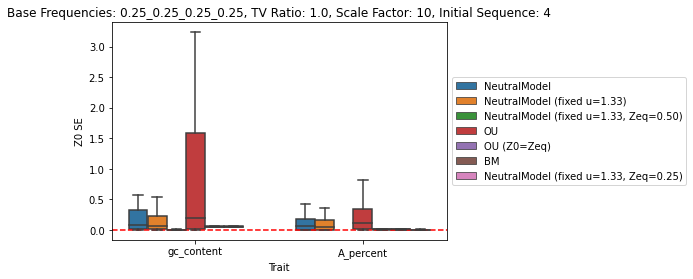

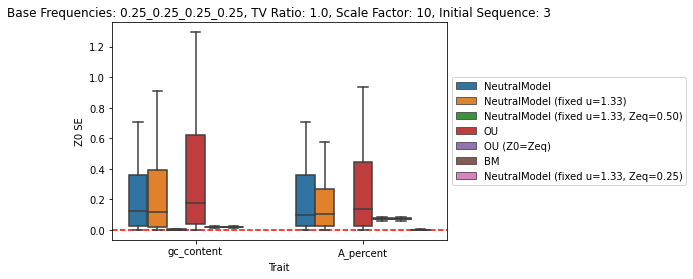

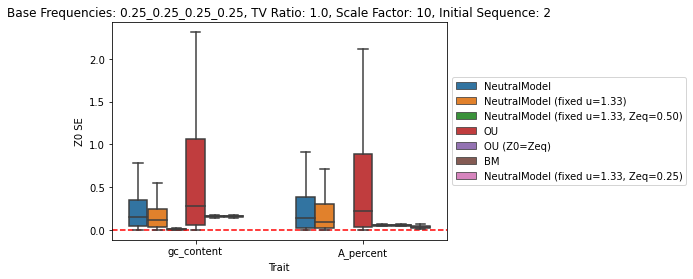

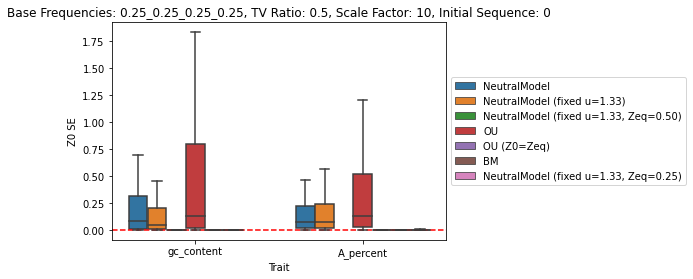

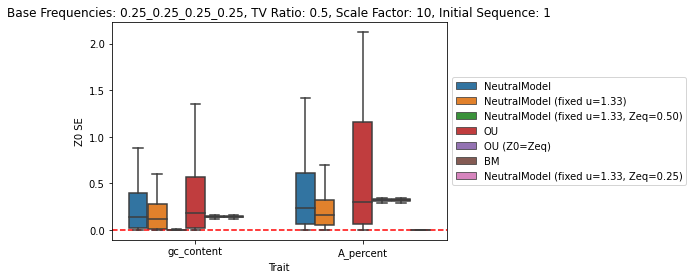

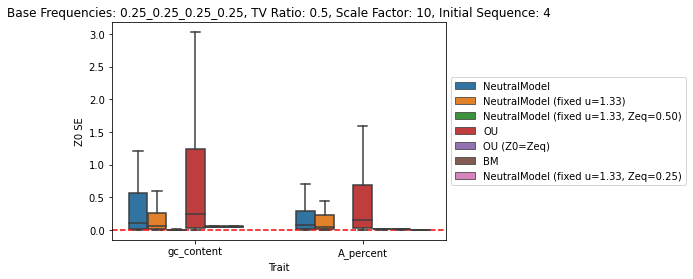

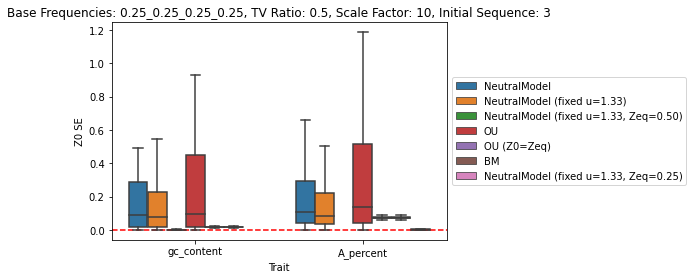

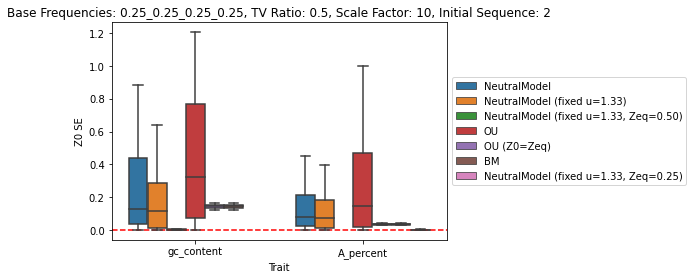

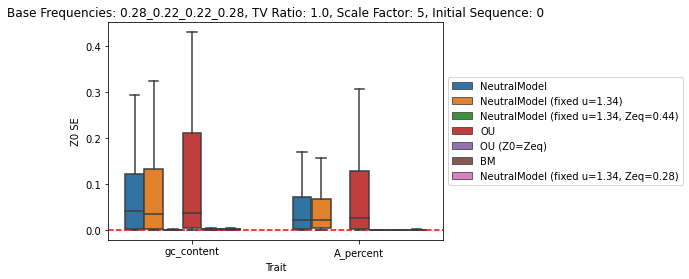

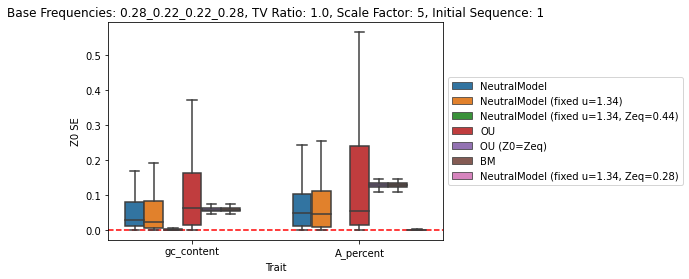

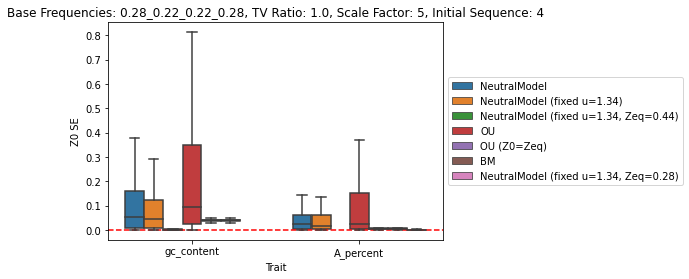

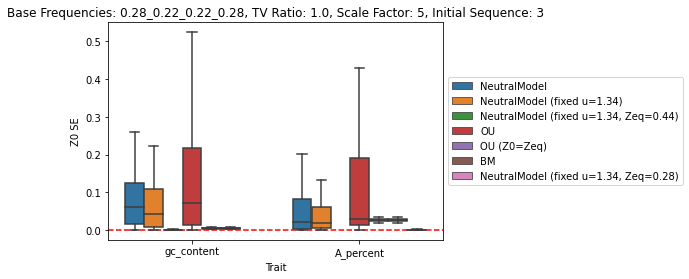

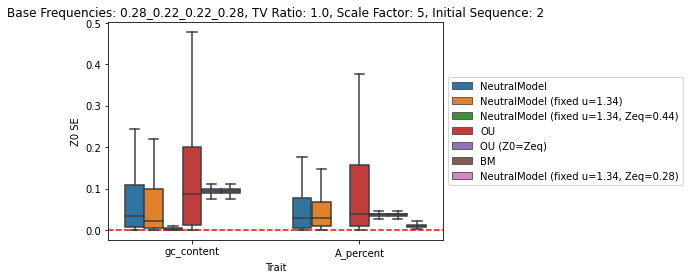

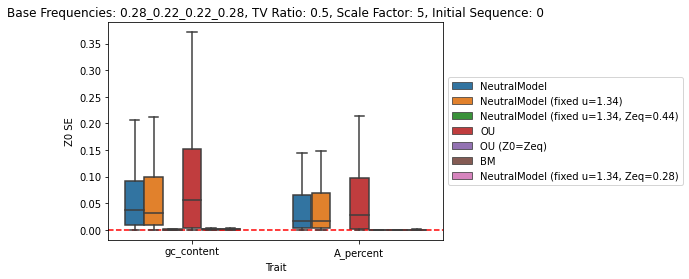

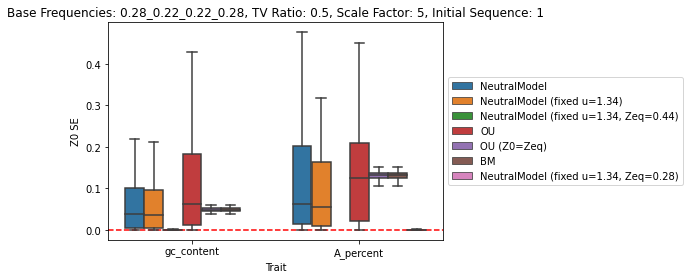

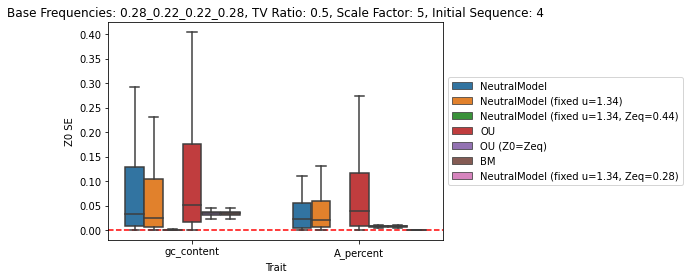

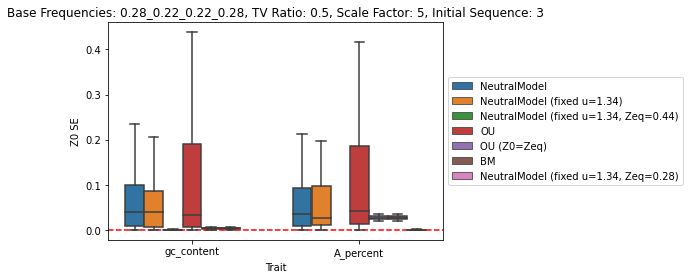

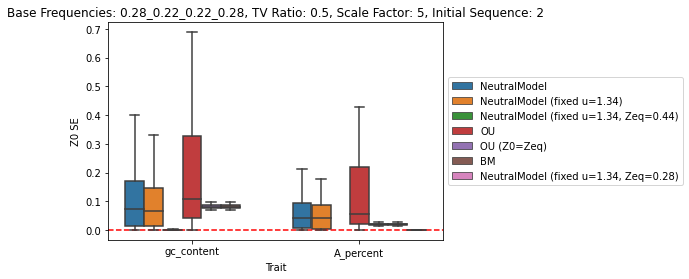

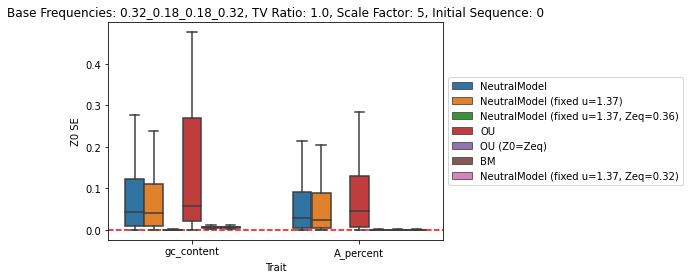

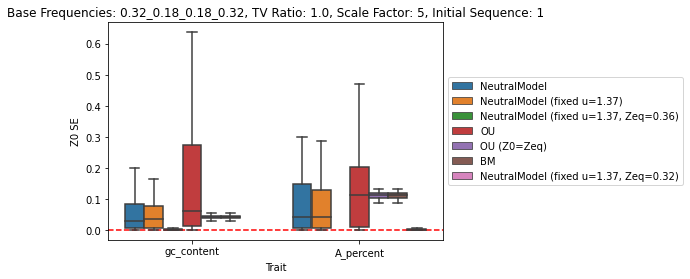

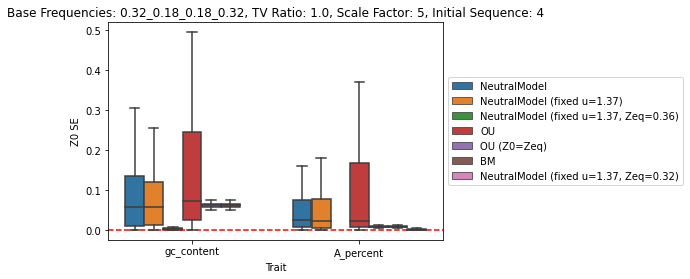

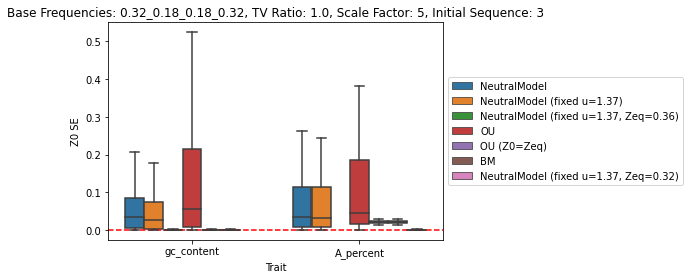

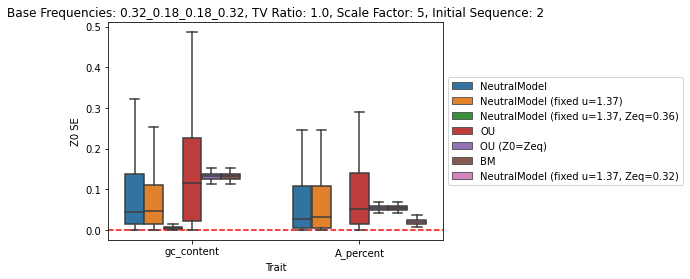

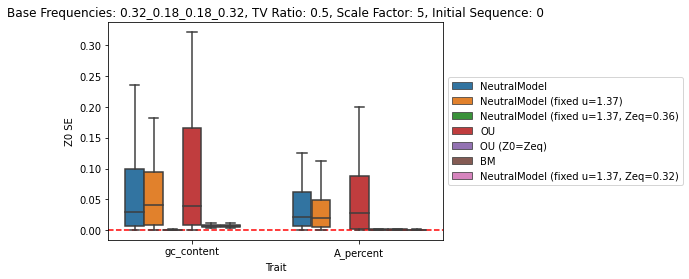

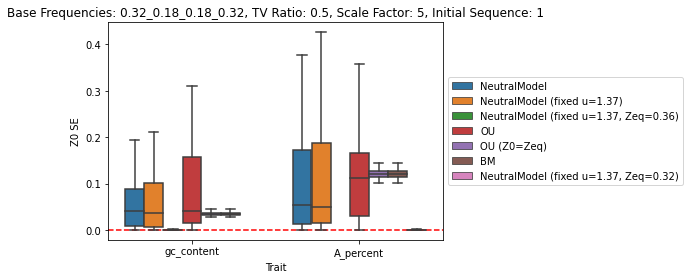

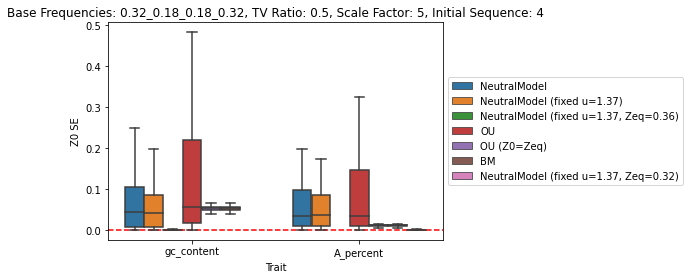

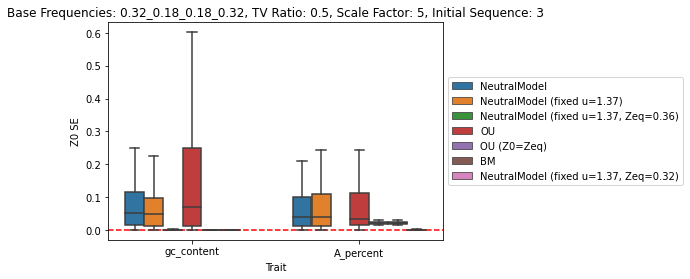

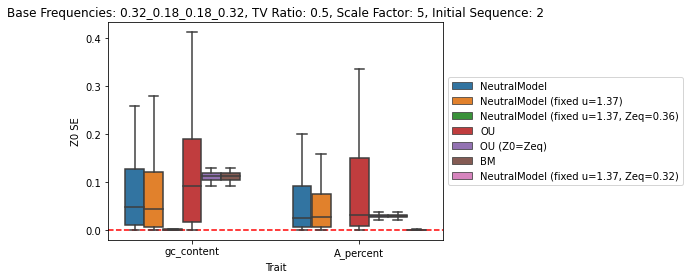

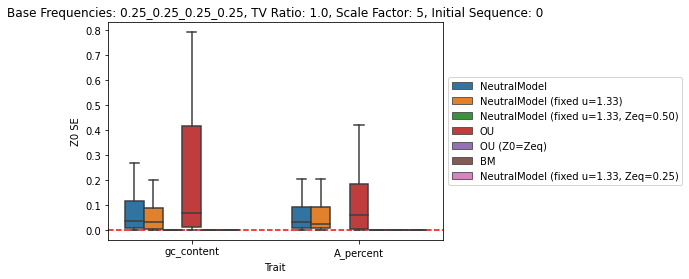

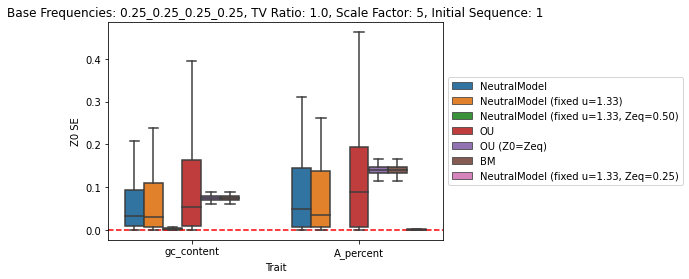

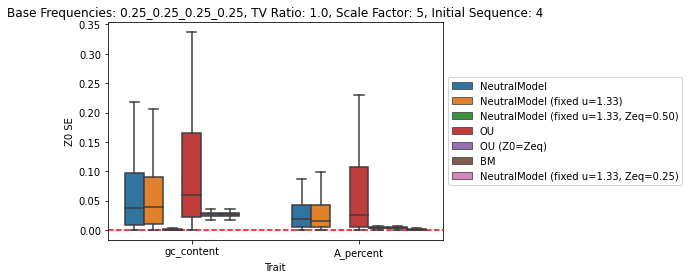

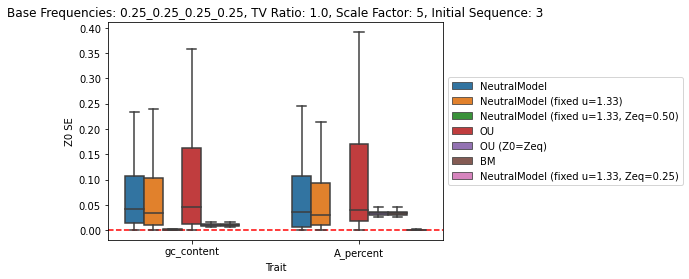

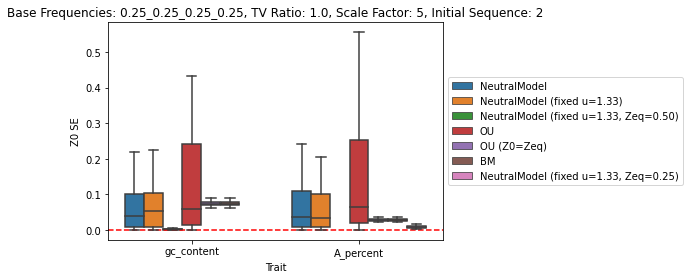

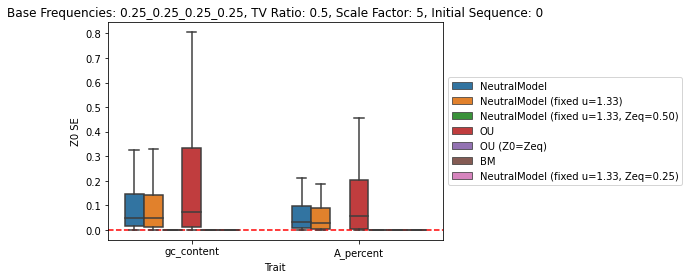

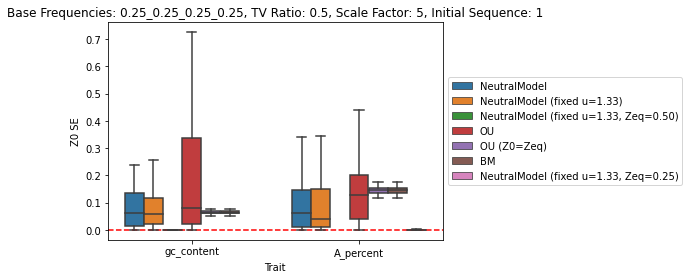

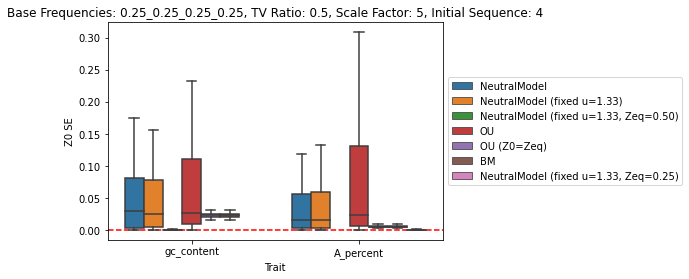

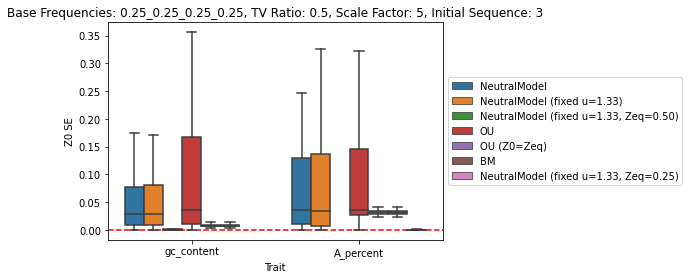

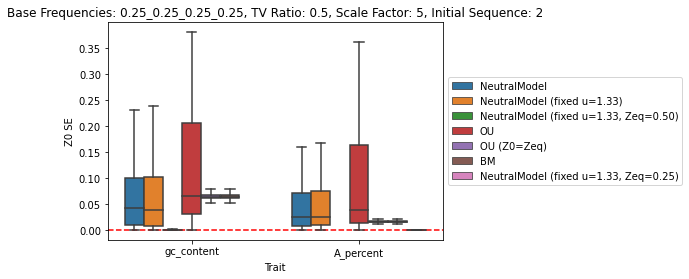

In [583]:
import itertools
for sf, bf, tv, ins in itertools.product(res_df['ScaleFactor'].unique(), res_df['BaseFreq'].unique(), res_df['TVRatio'].unique(), res_df['InitialSequence'].unique()):

    filt_df = res_df.loc[(res_df['ScaleFactor'] == sf) & (res_df['BaseFreq'] == bf) & 
                         (res_df['TVRatio'] == tv) & (res_df['InitialSequence'] == ins) &
                         (res_df['Trait'] != 'gaussian_es_trait')]
    
    ax = sns.boxplot(x="Trait", y='Z0 SE', hue="Model", data=filt_df, showfliers = False)
    plt.axhline(y=0., ls='--', c='r', zorder=1)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"Base Frequencies: {bf}, TV Ratio: {tv}, Scale Factor: {sf}, Initial Sequence: {ins}")
    plt.show()

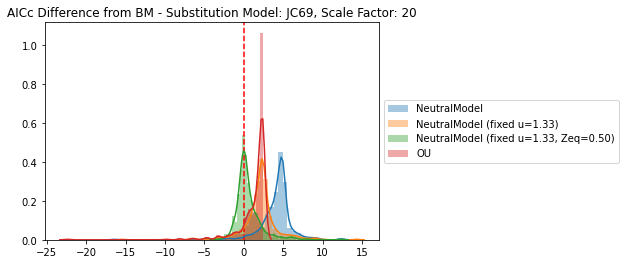

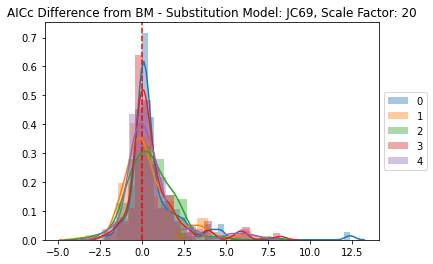

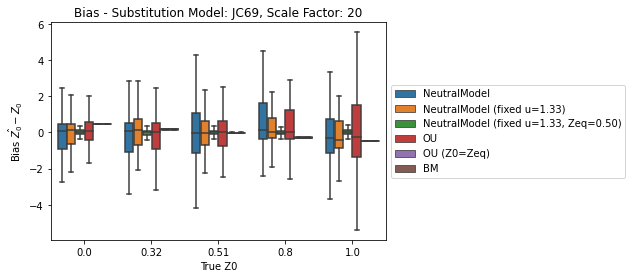

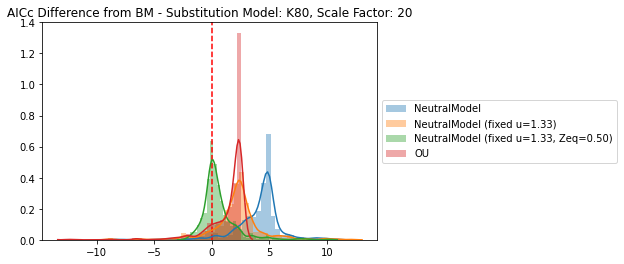

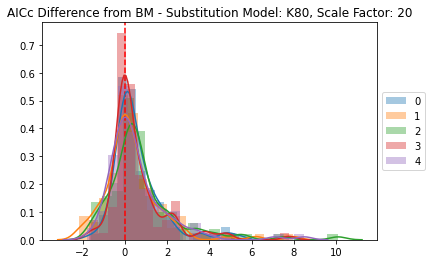

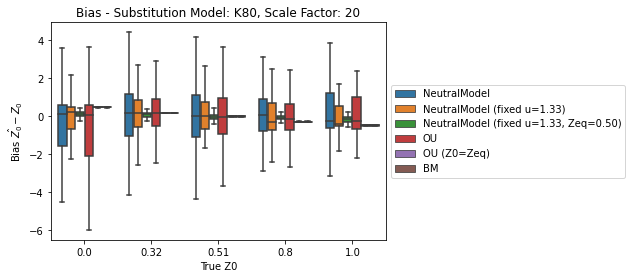

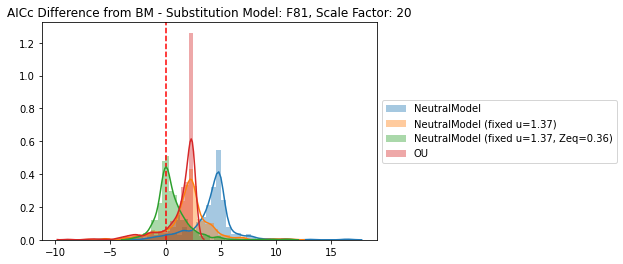

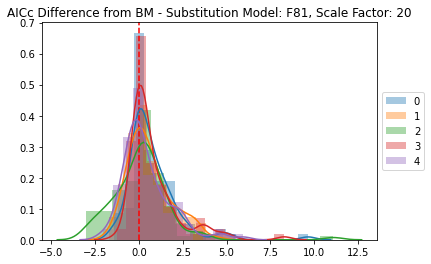

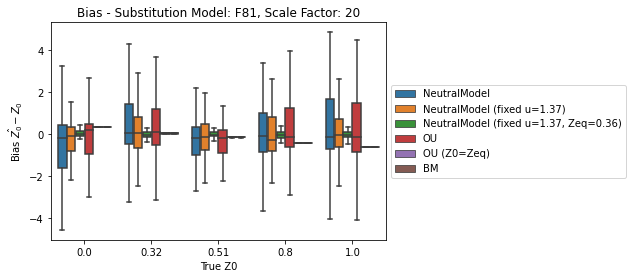

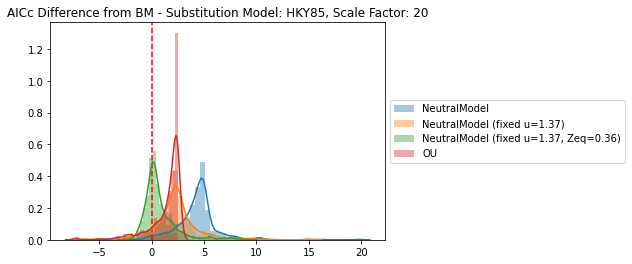

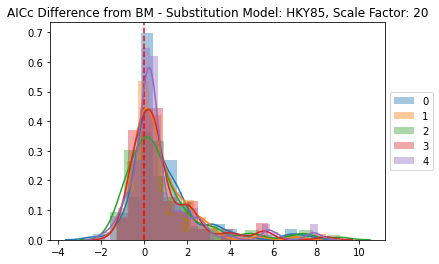

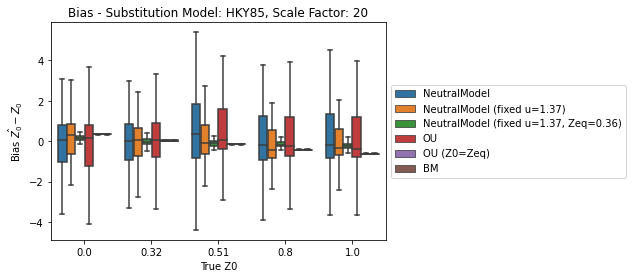

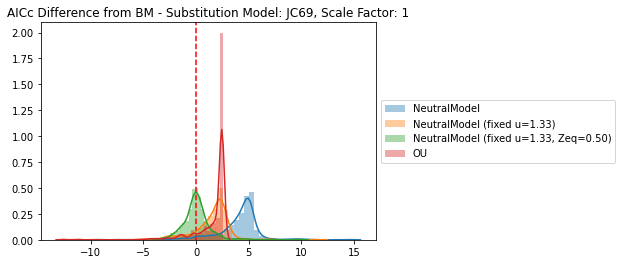

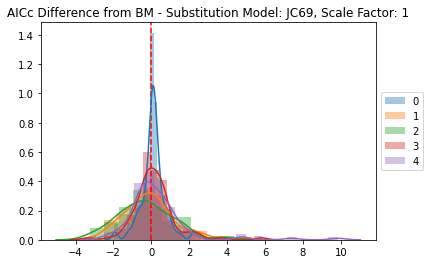

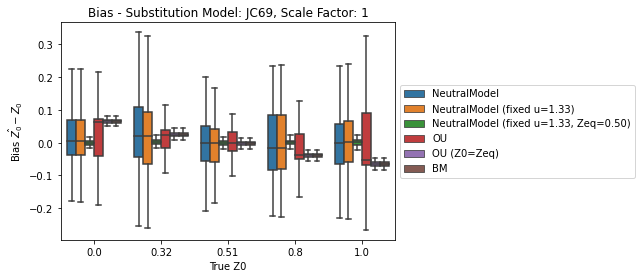

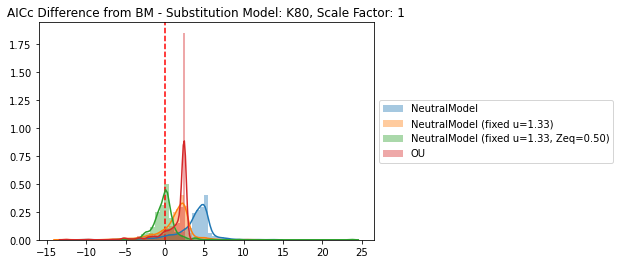

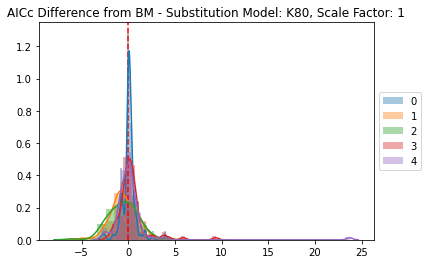

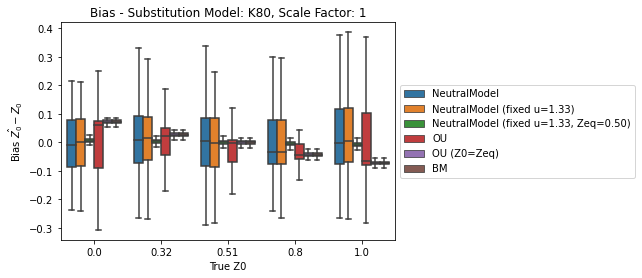

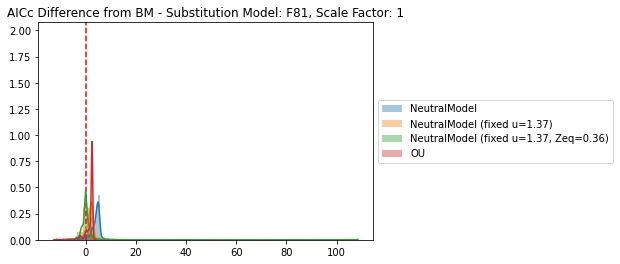

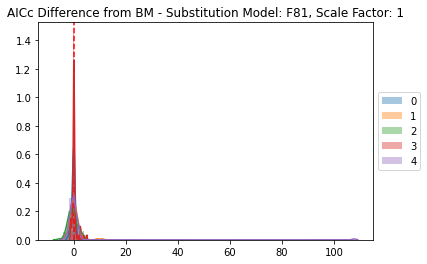

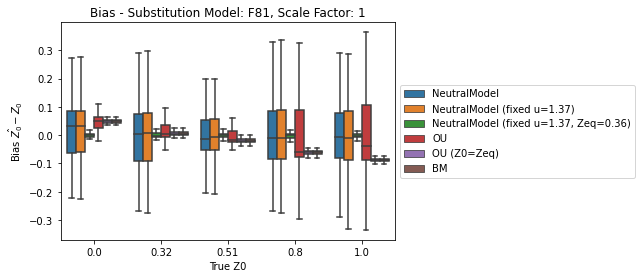

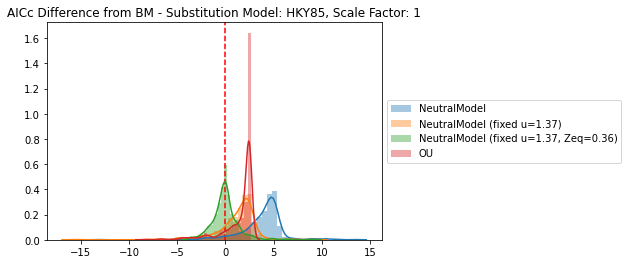

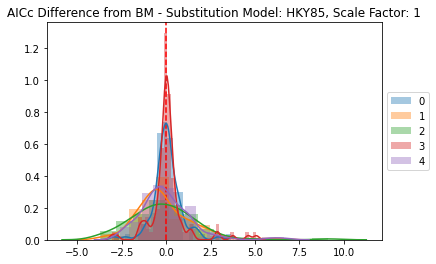

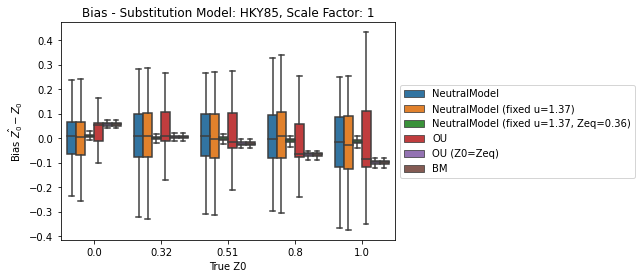

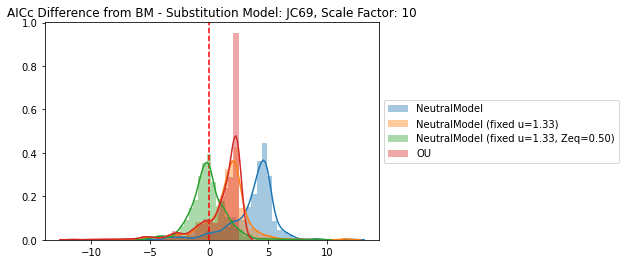

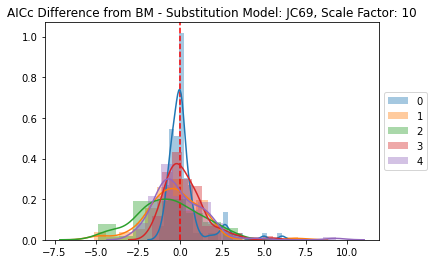

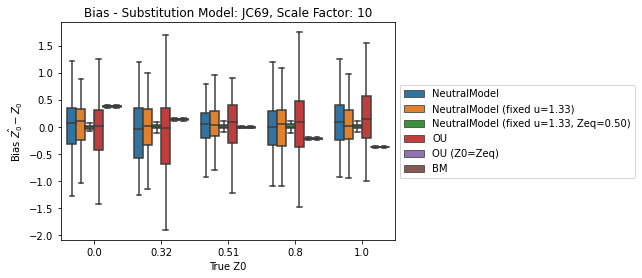

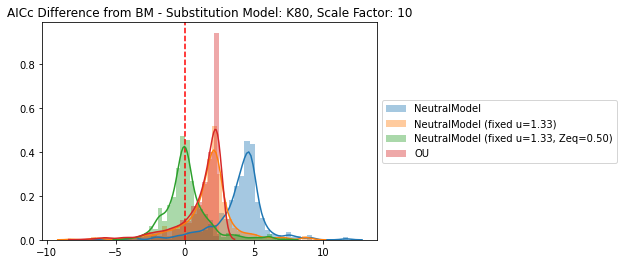

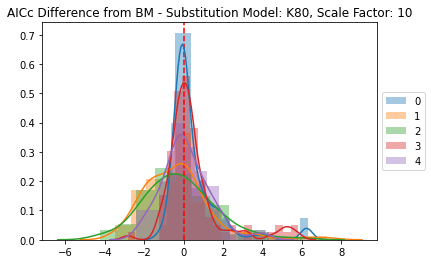

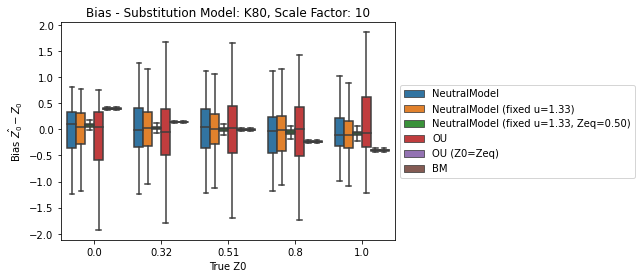

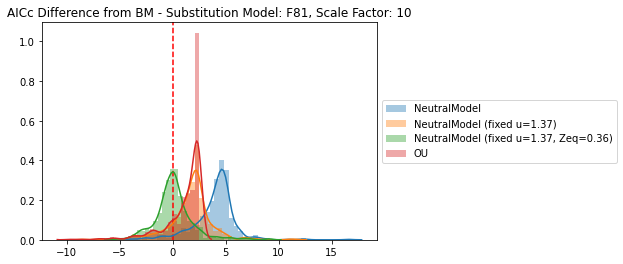

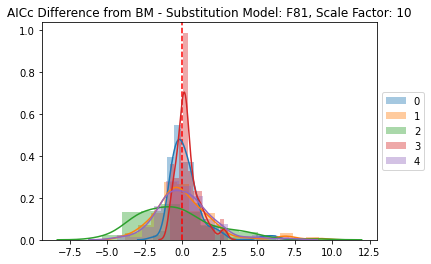

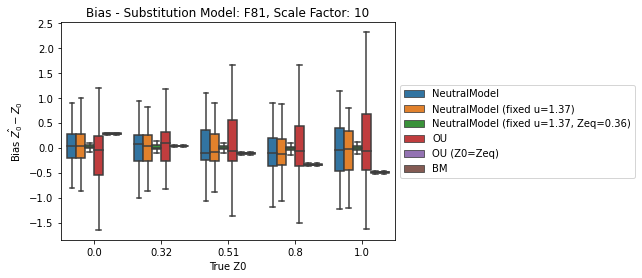

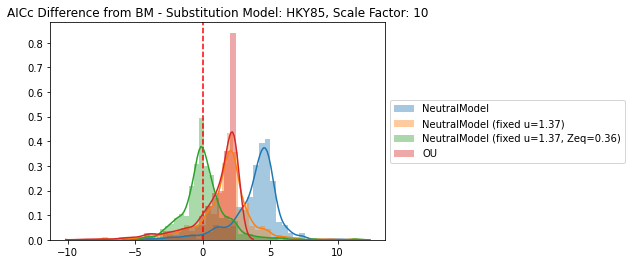

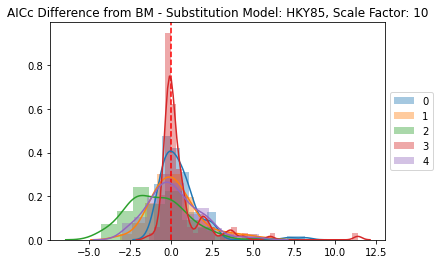

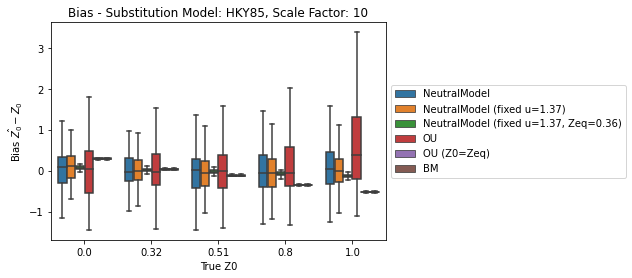

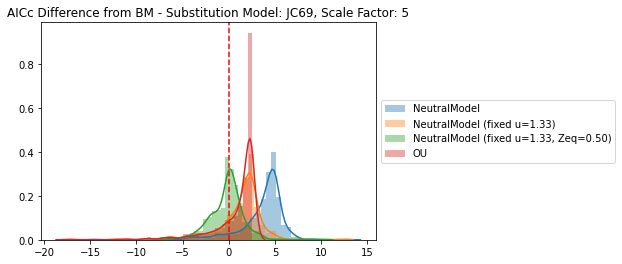

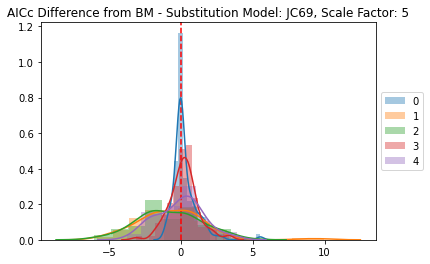

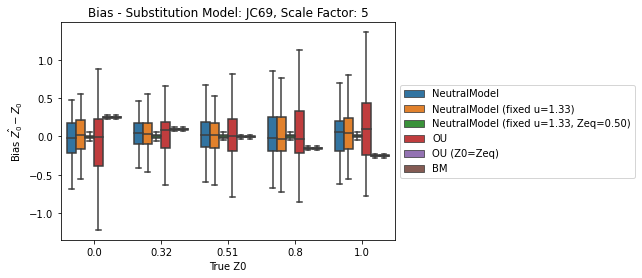

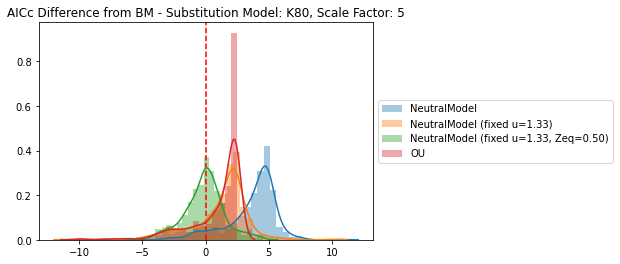

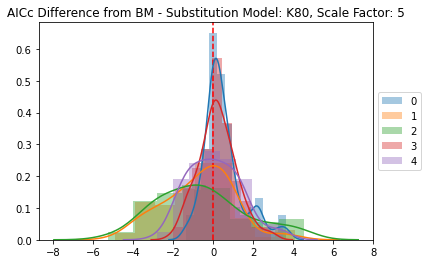

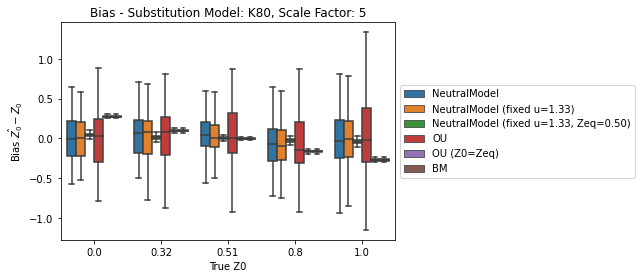

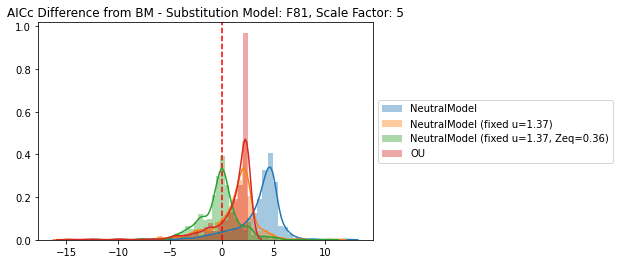

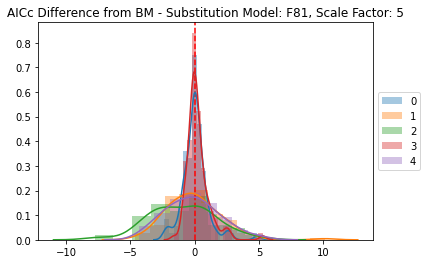

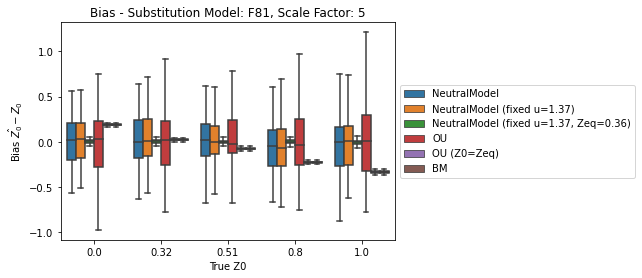

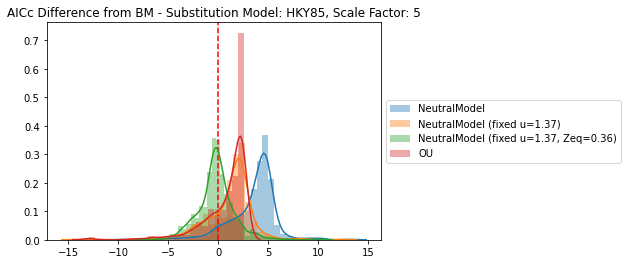

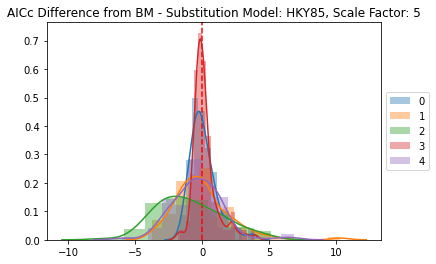

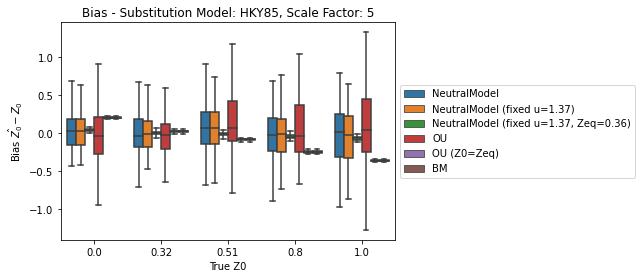

In [708]:
models = {
    'JC69': {
        'BaseFreq': ['0.25_0.25_0.25_0.25'],
        'TVRatio': 0.5
    },
    'K80': {
        'BaseFreq': ['0.25_0.25_0.25_0.25'],
        'TVRatio': 1.0
    },
    'F81': {
        'BaseFreq': ['0.32_0.18_0.18_0.32'],
        'TVRatio': 0.5
    },
    'HKY85': {
        'BaseFreq': ['0.32_0.18_0.18_0.32'],
        'TVRatio': 1.0
    }
}


x = 'BM'


for sf, (m, v) in itertools.product(res_df['ScaleFactor'].unique(), models.items()):

    filt_df = res_df.loc[(res_df['ScaleFactor'] == sf) & (res_df['BaseFreq'].isin(v['BaseFreq'])) & 
                             (res_df['TVRatio'] == v['TVRatio']) &
                             (res_df['Trait'] == 'gc_content')].copy()
    
    filt_mdf = filt_df.pivot(index=['BaseFreq','TVRatio','ScaleFactor','InitialSequence', 'Trait', 'Simulation'],
                   columns='Model', values='AICc').reset_index()

    
    #filt_df['Z0 SE'] = (filt_df['Inferred Z0'] - filt_df['True Z0'])**2
    #ax = sns.barplot(x='True Z0', y='Z0 SE', hue="Model", data=filt_df, ci=None)
    #plt.axhline(y=0., ls='--', c='r', zorder=1)
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.ylabel("Squared Error $(\hat{Z_0} - Z_0)^2$")
    #plt.title(f"Squared Error - Substitution Model: {m}, Scale Factor: {sf}")
    #plt.show()
    
    if m in ['JC69', 'K80']:
        y1 = 'NeutralModel (fixed u=1.33)'
        y2 = 'NeutralModel (fixed u=1.33, Zeq=0.50)'
    else:
        y1 = 'NeutralModel (fixed u=1.37)'
        y2 = 'NeutralModel (fixed u=1.37, Zeq=0.36)'
    
    sns.distplot((filt_mdf['NeutralModel'] - filt_mdf['BM']), label="NeutralModel")
    sns.distplot((filt_mdf[y1] - filt_mdf['BM']), label=y1)
    sns.distplot((filt_mdf[y2] - filt_mdf['BM']), label=y2)
    sns.distplot((filt_mdf['OU'] - filt_mdf['BM']), label='OU')
    #sns.distplot((filt_mdf['OU (Z0=Zeq)'] - filt_mdf['BM']), label='OU(Z0=Zeq)')
    plt.axvline(x=0., ls='--', c='r', zorder=1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"AICc Difference from BM - Substitution Model: {m}, Scale Factor: {sf}")
    plt.show()
    
    for iseq in np.unique(filt_mdf['InitialSequence']):
        n_filt_mdf = filt_mdf.loc[filt_mdf['InitialSequence'] == iseq]
        sns.distplot((n_filt_mdf[y2] - n_filt_mdf['BM']), label=iseq)
        #sns.distplot((filt_mdf[y1] - filt_mdf['BM']), label=y1)
        #sns.distplot((filt_mdf[y2] - filt_mdf['BM']), label=y2)
        #sns.distplot((filt_mdf['OU'] - filt_mdf['BM']), label='OU')
    #sns.distplot((filt_mdf['OU (Z0=Zeq)'] - filt_mdf['BM']), label='OU(Z0=Zeq)')
    plt.axvline(x=0., ls='--', c='r', zorder=1)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"AICc Difference from BM - Substitution Model: {m}, Scale Factor: {sf}")
    plt.show()
    
    filt_df['Z0 Bias'] = filt_df['Inferred Z0'] - filt_df['True Z0']
    ax = sns.boxplot(y='Z0 Bias', x='True Z0', hue='Model', data=filt_df, showfliers = False)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #plt.axhline(y=0., ls='--', c='r', zorder=1)
    plt.ylabel("Bias $\hat{Z_0} - Z_0$")
    plt.title(f"Bias - Substitution Model: {m}, Scale Factor: {sf}")
    plt.show()
    

In [680]:
filt_mdf.head()

Model             BaseFreq  TVRatio  ...          OU  OU (Z0=Zeq)
0      0.32_0.18_0.18_0.32      1.0  ... -156.973746  -156.419975
1      0.32_0.18_0.18_0.32      1.0  ... -155.834155  -158.310319
2      0.32_0.18_0.18_0.32      1.0  ... -151.565609  -153.236629
3      0.32_0.18_0.18_0.32      1.0  ... -164.737631  -162.319268
4      0.32_0.18_0.18_0.32      1.0  ... -171.848968  -172.463786

[5 rows x 12 columns]

Text(0.5, 1.0, 'AICc Difference from Brownian Motion')

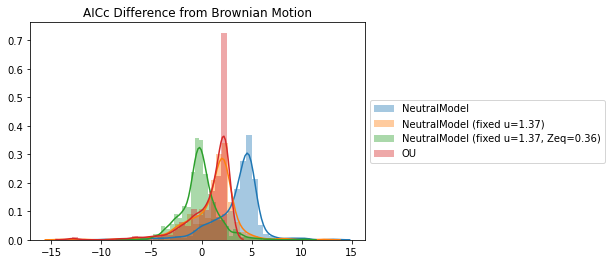

In [700]:
sns.distplot((filt_mdf['NeutralModel'] - filt_mdf['BM']), label="NeutralModel")
sns.distplot((filt_mdf['NeutralModel (fixed u=1.37)'] - filt_mdf['BM']), label="NeutralModel (fixed u=1.37)")
sns.distplot((filt_mdf['NeutralModel (fixed u=1.37, Zeq=0.36)'] - filt_mdf['BM']), label='NeutralModel (fixed u=1.37, Zeq=0.36)')
sns.distplot((filt_mdf['OU'] - filt_mdf['BM']), label='OU')
#sns.distplot((filt_mdf['OU (Z0=Zeq)'] - filt_mdf['BM']), label='OU(Z0=Zeq)')
#plt.axvline(x=0., ls='--', c='r', zorder=1)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("AICc Difference from Brownian Motion")